In [294]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import sem
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import ttest_rel,ttest_ind,wilcoxon
import json
import statsmodels.api as sm
import pylab as py

In [295]:
plt.rcParams.update(plt.rcParamsDefault)

In [296]:
home_dir = '/Users/dbao/google_drive_db'+'/road_construction/data/2022_online/'
home_dir = '../../../2022_online/'
map_dir = 'active_map/'
data_dir  = 'data/preprocessed'
# out_dir = home_dir + 'figures/cogsci_2022/'
out_dir = './figures_dk/'
R_out_dir = home_dir + 'R_analysis_data/'

In [297]:
data_puzzle_level = pd.read_csv(R_out_dir +  'data.csv')
puzzleID_order_data = data_puzzle_level.sort_values(["subjects","puzzleID"])
data_choice_level = pd.read_csv(R_out_dir +  'choice_level/choicelevel_data.csv')

single_condition_data = puzzleID_order_data[puzzleID_order_data['condition']==1].copy()
single_condition_data = single_condition_data.reset_index()
sc_data_choice_level = data_choice_level[data_choice_level['condition']==1].reset_index()

# Figure 1

## map

calculate direction of greedy choice and optimal choice to visualize the difference

In [298]:
with open(home_dir + map_dir + 'tree/map_tree_trueopt', 'r') as file:
    map_tree = json.load(file)

with open(home_dir + map_dir + '/basicMap.json', 'r') as file:
    map = json.load(file)

In [299]:
def find_sublist_index(target, list_of_sublists):
    try:
        return list_of_sublists.index(target)
    except ValueError:
        return -1  # returns -1 if the sublist is not found

In [300]:
# compariosn between performance
undo_level = data_choice_level[data_choice_level['condition']==1].copy().reset_index()
basic_level = data_choice_level[data_choice_level['condition']==0].copy().reset_index()

len_gdy_opt = []
len_diff = []

for sub in range(1):

    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    dat_sbj_undo  = undo_level[undo_level['subjects']==sub].sort_values(["puzzleID","index"])
    dat_sbj_basic  = basic_level[basic_level['subjects']==sub].sort_values(["puzzleID","index"])

    len_gdy_opt_puzzle = []

    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        TS = map[pzi]

        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()
        dat_sbj_undo_pzi = dat_sbj_undo[dat_sbj_undo['puzzleID'] == pzi].reset_index()
        dat_sbj_basic_pzi = dat_sbj_basic[dat_sbj_basic['puzzleID'] == pzi].reset_index()

        # get distance from TS['xy'][0] to TS['xy'][1:]
        start = np.array(TS['xy'][0])
        distance = [np.sum(np.sqrt((start - np.array(node))**2)) for node in TS['xy'][1:]]

        TS = map[pzi]

        R = 300.0

        rem_xy = TS['xy'].copy()
        # pop the current one
        curr_xy = rem_xy.pop(0)
        cts_in_order = []
        cts_in_order.append(curr_xy)
        cts_idx_in_order = [find_sublist_index(curr_xy, TS['xy'])]

        while R > 0:
            # get list of distances between curr_xy and every element in rem_xy
            # distance = [np.sum(np.sqrt((np.array(curr_xy) - np.array(node))**2)) for node in rem_xy]
            distance = [TS['distance'][find_sublist_index(curr_xy, TS['xy'])][find_sublist_index(node, TS['xy'])] for node in rem_xy]

            # find the argmin for distance
            idx = np.argmin(distance)

            curr_xy = rem_xy.pop(idx)

            R -= distance[idx]

            if R <= 0:
                break

            cts_in_order.append(curr_xy)
            cts_idx_in_order.append(find_sublist_index(curr_xy, TS['xy']))

        len_gdy = len(cts_in_order)
        len_opt = np.array(map_tree[pzi]['mas']).max()
        len_gdy_opt_puzzle.append([len_gdy, len_opt])
        opt_paths = map_tree[pzi]['paths'][np.argmax([len(path) for path in map_tree[pzi]['paths']])]

        len_diff.append(np.sum(np.array(cts_idx_in_order)[:4]==np.array(opt_paths)[:4]))

    # append mean of greedy_action_puzzle, error_action_puzzle
    len_gdy_opt.append(np.mean(len_gdy_opt_puzzle, axis=0))



len_gdy_opt = np.array(len_gdy_opt)

/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_46840/1059296280.py:61: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  len_diff.append(np.sum(np.array(cts_idx_in_order)[:4]==np.array(opt_paths)[:4]))


Found puzzle ID that clearly seperates both

In [301]:
pzi = 44 # where it goes in different direction

In [302]:
TS = map[pzi]

# get greedy paths coordinations
R = 300.0

rem_xy = TS['xy'].copy()
# pop the current one
curr_xy = rem_xy.pop(0)
cts_in_order = []
cts_in_order.append(curr_xy)

while R > 0:
    # get list of distances between curr_xy and every element in rem_xy
    # distance = [np.sum(np.sqrt((np.array(curr_xy) - np.array(node))**2)) for node in rem_xy]
    distance = [TS['distance'][find_sublist_index(curr_xy, TS['xy'])][find_sublist_index(node, TS['xy'])] for node in rem_xy]

    # find the argmin for distance
    idx = np.argmin(distance)

    curr_xy = rem_xy.pop(idx)


    if R - distance[idx] <= 0:
        break

    R -= distance[idx]

    cts_in_order.append(curr_xy)

# get optimal paths coordinations
paths = map_tree[pzi]['paths'][np.argmax([len(path) for path in map_tree[pzi]['paths']])]

cts_in_order_optimal = [TS['xy'][path] for path in paths]


In [303]:
# sum of TS['distance'] for each pair of paths
opt_R = 0
for i in range(1,len(paths)):
    opt_R += TS['distance'][paths[i-1]][paths[i]]
opt_R = 300 - opt_R

In [304]:
print('greedy: ',R)
print('optimal: ',opt_R)

greedy:  99.87597775993959
optimal:  6.619203947013489


calculate remaining budget too

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


99.87597775993959


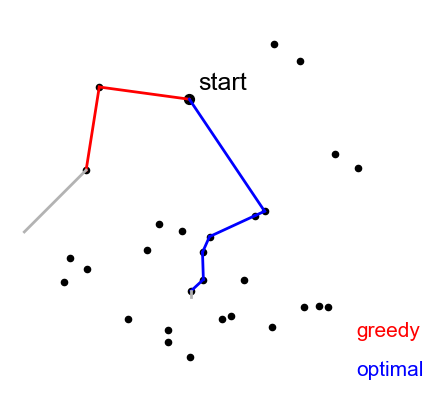

In [305]:
# plot line with dots for cts_in_order and cts_in_order_optimal
%matplotlib inline
fig, ax = plt.subplots(figsize=(5,5))

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 15

# plot the map
for i in range(len(TS['xy'])):
    ax.scatter(TS['xy'][i][0], TS['xy'][i][1], color='black', s=20)

# for i in range(len(TS['xy'])):
#     ax.annotate(i, (TS['xy'][i][0], TS['xy'][i][1]), fontsize=20)


# plot the greedy path
for i in range(len(cts_in_order)-1):
    ax.plot([cts_in_order[i][0], cts_in_order[i+1][0]], [cts_in_order[i][1], cts_in_order[i+1][1]], color='red', linewidth=2, alpha=1)

ax.plot([cts_in_order[-1][0], cts_in_order[-1][0]-R/np.sqrt(2)], [cts_in_order[-1][1], cts_in_order[-1][1]-R/np.sqrt(2)], color='0.7', linewidth=2, alpha=1)
# print distance between two dots
print(np.sqrt((cts_in_order[-1][0]-R/np.sqrt(2) - cts_in_order[-1][0])**2 + (cts_in_order[-1][1]-R/np.sqrt(2) - cts_in_order[-1][1])**2))

# plot the optimal path
for i in range(len(cts_in_order_optimal)-1):
    ax.plot([cts_in_order_optimal[i][0], cts_in_order_optimal[i+1][0]], [cts_in_order_optimal[i][1], cts_in_order_optimal[i+1][1]], color='blue', linewidth=2, alpha=1)

ax.plot([cts_in_order_optimal[-1][0], cts_in_order_optimal[-1][0]], [cts_in_order_optimal[-1][1], cts_in_order_optimal[-1][1]-opt_R], color='0.7', linewidth=2, alpha=1)


# grid off
ax.grid(False)

# remove all borders
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# plot the start point in front of everything
ax.scatter(TS['xy'][0][0], TS['xy'][0][1], color='k', s=50, marker='o', alpha=1)
ax.annotate('start', (TS['xy'][0][0]+10, TS['xy'][0][1]+10), fontsize=18)

# x lim y lim
ax.set_xlim([-220, 220])
ax.set_ylim([-220, 220])

# x ticks and y ticks
ax.set_xticks([])
ax.set_yticks([])

# make axis equal
ax.set_aspect('equal')

# legend
# ax.plot([], [], color='red', linewidth=2, label='greedy')
# ax.plot([], [], color='blue', linewidth=2, label='optimal')

# red and blue text for greedy and optimal
ax.text(0.9, 0.15, 'greedy', transform=ax.transAxes, color='red', fontsize=15)
ax.text(0.9, 0.05, 'optimal', transform=ax.transAxes, color='blue', fontsize=15)

# ax.plot([], [], color='0.7', linewidth=2, label='leftover')
# legend that without box
plt.legend(fontsize=15, loc='lower right', frameon=False)
# save figure
plt.savefig(out_dir + 'greedy_vs_optimal.png')
plt.show()


## Error magnitude histogram|


In [306]:
import matplotlib
matplotlib.rcdefaults()

In [307]:
# compariosn between performance
undo_level = data_choice_level[data_choice_level['condition']==1].copy().reset_index()
basic_level = data_choice_level[data_choice_level['condition']==0].copy().reset_index()

error_magnitude = []
error_magnitude_mean = []

error_magnitude_mean_didnotundo = []
error_magnitude_mean_didundo = []

optimality_firstmove = []

greedy_action = []
error_action = []
leftover = []

num_undo_per_mas = []
total_RT_per_mas = []
total_RT_per_mas_undoallowed = []
cumul_error_mag_per_mas = []


for sub in range(100):

    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    dat_sbj_undo  = undo_level[undo_level['subjects']==sub].sort_values(["puzzleID","index"])
    dat_sbj_basic  = basic_level[basic_level['subjects']==sub].sort_values(["puzzleID","index"])

    error_magnitude_puzzle = []

    error_magnitude_mean_didnotundo_puzzle = []
    error_magnitude_mean_didundo_puzzle = []

    optimality_firstmove_puzzle = []

    greedy_action_puzzle = []
    error_action_puzzle = []
    leftover_puzzle = []

    num_undo_per_mas_puzzle = []
    total_RT_per_mas_puzzle = []

    total_RT_per_mas_undoallowed_puzzle = []

    cumul_error_mag_per_mas_puzzle = []

    for pzi in np.unique(sc_data_choice_level['puzzleID']):

        TS = map[pzi]

        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()
        dat_sbj_undo_pzi = dat_sbj_undo[dat_sbj_undo['puzzleID'] == pzi].reset_index()
        dat_sbj_basic_pzi = dat_sbj_basic[dat_sbj_basic['puzzleID'] == pzi].reset_index()

        error_magnitude_puzzle.append([np.array(dat_sbj_undo_pzi['currMas'])[-1]-np.array(dat_sbj_undo_pzi['currMas'])[0],
                                  np.array(dat_sbj_basic_pzi['currMas'])[-1]-np.array(dat_sbj_basic_pzi['currMas'])[0]])

        # check if dat_sbj_undo_pzi['undo'].sum() is 0 or not
        if dat_sbj_undo_pzi['undo'].sum() == 0:
            error_magnitude_mean_didnotundo_puzzle.append([np.array(dat_sbj_undo_pzi['currMas'])[-1]-np.array(dat_sbj_undo_pzi['currMas'])[0],
                                                           np.array(dat_sbj_basic_pzi['currMas'])[-1]-np.array(dat_sbj_basic_pzi['currMas'])[0]])
        else:
            error_magnitude_mean_didundo_puzzle.append([np.array(dat_sbj_undo_pzi['currMas'])[-1]-np.array(dat_sbj_undo_pzi['currMas'])[0],
                                                        np.array(dat_sbj_basic_pzi['currMas'])[-1]-np.array(dat_sbj_basic_pzi['currMas'])[0]])

        optimality_firstmove_puzzle.append([dat_sbj_undo_pzi['currMas'][1]-dat_sbj_undo_pzi['currMas'][0],
                                            dat_sbj_basic_pzi['currMas'][1]-dat_sbj_basic_pzi['currMas'][0]])

        # get distance from TS['xy'][0] to TS['xy'][1:]
        start = np.array(TS['xy'][0])
        # distance = [np.sum(np.sqrt((start - np.array(node))**2)) for node in TS['xy'][1:]]
        distance = [np.sum(np.sqrt((start - np.array(node))**2)) for node in TS['xy']]

        # find the index that is second shortest distance because the first shortest is goint back to itself
        idx = np.argsort(distance)[1]

        # get proportion of data_sbj_undo_pzi['choice'][1] == idx
        greedy_action_puzzle.append([np.double(dat_sbj_undo_pzi['choice'][1] == idx),
                                     np.double(dat_sbj_basic_pzi['choice'][1] == idx)])

        # get proportion of data_sbj_undo_pzi['currMas'][1] is smaller than data_sbj_undo_pzi['currMas'][0]
        error_action_puzzle.append([np.double(dat_sbj_undo_pzi['currMas'][1] < dat_sbj_undo_pzi['currMas'][0]),
                                    np.double(dat_sbj_basic_pzi['currMas'][1] < dat_sbj_basic_pzi['currMas'][0])])

        leftover_puzzle.append([np.array(dat_sbj_undo_pzi['leftover'])[-1], np.array(dat_sbj_basic_pzi['leftover'])[-1]])

        # append number of undos and puzzle MAS
        num_undo_per_mas_puzzle.append([np.array(dat_sbj_undo_pzi['undo']).sum(), dat_sbj_undo_pzi['currMas'][0]])
        total_RT_per_mas_puzzle.append([np.array(dat_sbj_basic_pzi['RT'][1:]).sum(), dat_sbj_basic_pzi['currMas'][0]])
        total_RT_per_mas_undoallowed_puzzle.append([np.array(dat_sbj_undo_pzi['RT'][1:]).sum(), dat_sbj_undo_pzi['currMas'][0]])

        # append cumulative error magnitude
        cumul_error_mag_per_mas_puzzle.append([np.array(dat_sbj_undo_pzi['currMas'])[-1]-np.array(dat_sbj_undo_pzi['currMas'])[0],
                                               np.array(dat_sbj_basic_pzi['currMas'])[-1]-np.array(dat_sbj_basic_pzi['currMas'])[0], dat_sbj_undo_pzi['currMas'][0]])

    # extend point_loss
    hist_undo = np.histogram(np.array(error_magnitude_puzzle)[:,0], bins=[-np.inf, *np.arange(-4,1,1)])[0].astype(dtype=np.float32)
    hist_undo /= hist_undo.sum()
    hist_basic = np.histogram(np.array(error_magnitude_puzzle)[:,1], bins=[-np.inf, *np.arange(-4,1,1)])[0].astype(dtype=np.float32)
    hist_basic /= hist_basic.sum()

    error_magnitude.append([*hist_undo, *hist_basic])

    # append mean of greedy_action_puzzle, error_action_puzzle
    greedy_action.append(np.mean(greedy_action_puzzle, axis=0))
    error_action.append(np.mean(error_action_puzzle, axis=0))
    error_magnitude_mean.append([np.mean(np.array(error_magnitude_puzzle)[:,0]),np.mean(np.array(error_magnitude_puzzle)[:,1])])
    if len(error_magnitude_mean_didnotundo_puzzle) == 0:
        error_magnitude_mean_didundo.append([np.nan,np.nan])
    else:
        error_magnitude_mean_didnotundo.append(np.mean(error_magnitude_mean_didnotundo_puzzle,axis=0))

    if len(error_magnitude_mean_didundo_puzzle) == 0:
        error_magnitude_mean_didundo.append([np.nan,np.nan])
    else:
        error_magnitude_mean_didundo.append(np.nanmean(error_magnitude_mean_didundo_puzzle,axis=0))

    optimality_firstmove.append(np.nanmean(optimality_firstmove_puzzle, axis=0))

    leftover.append(np.mean(leftover_puzzle, axis=0))

    # append number of undos and puzzle MAS
    num_undo_per_mas.append(num_undo_per_mas_puzzle)
    total_RT_per_mas.append(total_RT_per_mas_puzzle)
    total_RT_per_mas_undoallowed.append(total_RT_per_mas_undoallowed_puzzle)

    # append cumulative error magnitude
    cumul_error_mag_per_mas.append(cumul_error_mag_per_mas_puzzle)


greedy_action = np.array(greedy_action)
error_action = np.array(error_action)
error_magnitude = np.array(error_magnitude)
error_magnitude_mean = np.array(error_magnitude_mean)
error_magnitude_mean_didnotundo = np.array(error_magnitude_mean_didnotundo)
error_magnitude_mean_didundo = np.array(error_magnitude_mean_didundo)
leftover = np.array(leftover)

optimality_firstmove = np.array(optimality_firstmove)

num_undo_per_mas = np.array(num_undo_per_mas)
total_RT_per_mas = np.array(total_RT_per_mas)
total_RT_per_mas_undoallowed = np.array(total_RT_per_mas_undoallowed)

cumul_error_mag_per_mas = np.array(cumul_error_mag_per_mas)
cumul_error_mag_per_mas = np.abs(cumul_error_mag_per_mas)


## number of undos per mas

In [308]:
# calculate for each subject
num_undo_mas_persub =[]
total_RT_mas_persub_undoNotAllowed = []
total_RT_mas_persub_undoAllowed = []
cumul_error_mag_mas_persub_UA = [] #0
cumul_error_mag_mas_persub_UNA = [] #1

for sub in range(100):
    num_undo_mas_persub_mas = []
    total_RT_mas_persub_mas_undoNotAllowed = []
    total_RT_mas_persub_mas_undoAllowed = []

    cumul_error_mag_mas_persub_UA_mas = []
    cumul_error_mag_mas_persub_UNA_mas = []

    for j in range(7,13):
        # if num_undo_per_mas[sub,:,1] == j:
        num_undo_mas_persub_mas.append(num_undo_per_mas[sub,num_undo_per_mas[sub,:,1] == j,0].mean())
        total_RT_mas_persub_mas_undoNotAllowed.append(total_RT_per_mas[sub,total_RT_per_mas[sub,:,1] == j,0].mean())
        total_RT_mas_persub_mas_undoAllowed.append(total_RT_per_mas_undoallowed[sub,total_RT_per_mas_undoallowed[sub,:,1] == j,0].mean())

        cumul_error_mag_mas_persub_UA_mas.append(cumul_error_mag_per_mas[sub,cumul_error_mag_per_mas[sub,:,2] == j,0].mean())
        cumul_error_mag_mas_persub_UNA_mas.append(cumul_error_mag_per_mas[sub,cumul_error_mag_per_mas[sub,:,2] == j,1].mean())
    num_undo_mas_persub.append(num_undo_mas_persub_mas)
    total_RT_mas_persub_undoNotAllowed.append(total_RT_mas_persub_mas_undoNotAllowed)
    total_RT_mas_persub_undoAllowed.append(total_RT_mas_persub_mas_undoAllowed)

    cumul_error_mag_mas_persub_UA.append(cumul_error_mag_mas_persub_UA_mas)
    cumul_error_mag_mas_persub_UNA.append(cumul_error_mag_mas_persub_UNA_mas)
num_undo_mas_persub = np.array(num_undo_mas_persub)
total_RT_mas_persub_undoNotAllowed = np.array(total_RT_mas_persub_undoNotAllowed)/1000
total_RT_mas_persub_undoAllowed = np.array(total_RT_mas_persub_undoAllowed)/1000

cumul_error_mag_mas_persub_UA = np.array(cumul_error_mag_mas_persub_UA)
cumul_error_mag_mas_persub_UNA = np.array(cumul_error_mag_mas_persub_UNA)

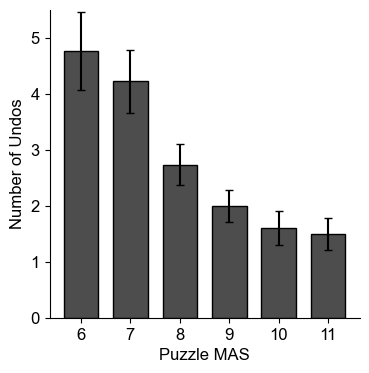

In [309]:
%matplotlib inline

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.figure(figsize=(4,4))

# plot bar of num_undo_mas_persub
plt.bar(np.arange(6,12,1), num_undo_mas_persub.mean(axis=0), width=0.7, color='0.3', alpha=1, edgecolor='k', yerr=num_undo_mas_persub.std(axis=0)/np.sqrt(100), capsize=3)

# x and y label
plt.xlabel('Puzzle MAS')
plt.ylabel('Number of Undos')

# set x and y limit
plt.ylim([0, 5.5])

# set xticks and yticks
plt.xticks(np.arange(6,12,1))
plt.yticks(np.arange(0,6,1))

sns.despine()

# save
plt.savefig( out_dir + '/num_undo_per_mas.png', bbox_inches='tight', transparent=True)


In [310]:
# statistical test using ANOVA for num_undo_mas_persub

# group-wise for different MAS
g1 = num_undo_mas_persub[:,0]
g2 = num_undo_mas_persub[:,1]
g3 = num_undo_mas_persub[:,2]
g4 = num_undo_mas_persub[:,3]
g5 = num_undo_mas_persub[:,4]
g6 = num_undo_mas_persub[:,5]

# anova
f_val, p_val = stats.f_oneway(g1,g2,g3,g4,g5,g6)

# print stat result
print('ANOVA for num_undo_mas_persub')
print('F = ', f_val, 'p = ', p_val)


ANOVA for num_undo_mas_persub
F =  9.573555188074371 p =  8.456726307867146e-09


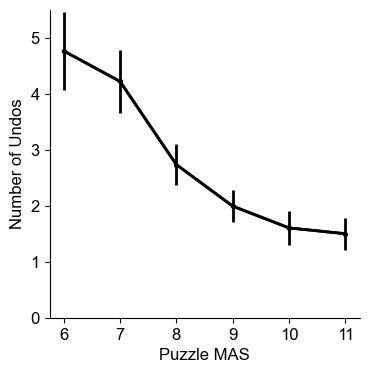

In [311]:
%matplotlib inline

# set font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(4,4))

# get two colors distinguishable for who cannot see red and green
colors= ['0', '0.5']

# line plot with error bar for num_undo_mas_persub
plt.plot(np.arange(6,12,1), np.mean(num_undo_mas_persub, axis=0), color=colors[0], linewidth=2, marker='.', markersize=5, label='Later-move RT')
plt.errorbar(np.arange(6,12,1), np.mean(num_undo_mas_persub, axis=0), yerr=np.std(num_undo_mas_persub, axis=0)/np.sqrt(100), color=colors[0], linewidth=2, marker='.', markersize=5, label=None)

# set x and y label
plt.xlabel('Puzzle MAS')
plt.ylabel('Number of Undos')

# set x and y limit
plt.ylim([0, 5.5])

# set xticks and yticks
plt.xticks(np.arange(6,12,1))
plt.yticks(np.arange(0,6,1))

sns.despine()

# save
plt.savefig( out_dir + '/num_undo_per_mas.png', bbox_inches='tight', transparent=True)


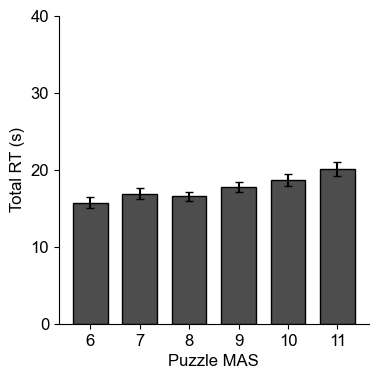

In [312]:
%matplotlib inline

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.figure(figsize=(4,4))

# plot bar of total_RT_mas_persub
plt.bar(np.arange(6,12,1), total_RT_mas_persub_undoNotAllowed.mean(axis=0), width=0.7, color='0.3', alpha=1, edgecolor='k', yerr=total_RT_mas_persub_undoNotAllowed.std(axis=0)/np.sqrt(100), capsize=3)

# x and y label
plt.xlabel('Puzzle MAS')
plt.ylabel('Total RT (s)')

# set x and y limit
plt.ylim([0, 40])

# set xticks and yticks
plt.xticks(np.arange(6,12,1))
plt.yticks(np.arange(0,41,10))

sns.despine()

# save
plt.savefig( out_dir + '/total_RT_per_mas.png', bbox_inches='tight', transparent=True)

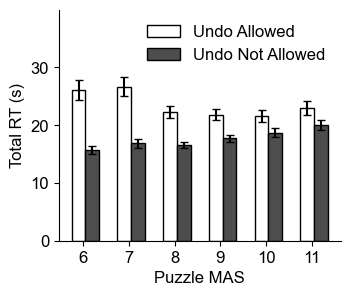

In [313]:
%matplotlib inline
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
# numpy hist for point_loss[:,0]

# plot bar plot of hist_undo
plt.bar(np.arange(-0.1,5.8,1), total_RT_mas_persub_undoAllowed.mean(axis=0), width=0.3, color='1', alpha=1, label='Undo Allowed', edgecolor='k')
# plot error bar
plt.errorbar(np.arange(-0.1,5.8,1), total_RT_mas_persub_undoAllowed.mean(axis=0), yerr=total_RT_mas_persub_undoAllowed.std(axis=0)/np.sqrt(100), fmt='none', color='k', capsize=3)

# plot bar plot of hist_basic
plt.bar(np.arange(0.2,6.2,1), total_RT_mas_persub_undoNotAllowed.mean(axis=0), width=0.3, color='0.3', alpha=1, label='Undo Not Allowed', edgecolor='k')
# plot error bar
plt.errorbar(np.arange(0.2,6.2,1), total_RT_mas_persub_undoNotAllowed.mean(axis=0), yerr=total_RT_mas_persub_undoNotAllowed.std(axis=0)/np.sqrt(100), fmt='none', color='k', capsize=3)


plt.xlabel('Puzzle MAS')
plt.ylabel('Total RT (s)')

# plt.legend that without box
plt.legend(frameon=False)

# delete top and right frame using plt
sns.despine()

# set ylim
plt.ylim([0, 40])

# set xticks
plt.xticks(np.arange(0,6,1), ['6','7','8','9','10','11'])

# set yticks
plt.yticks(np.arange(0,40,10))

# save figure
plt.savefig(out_dir + '/total_RT.png', dpi=300, bbox_inches='tight')
plt.show()



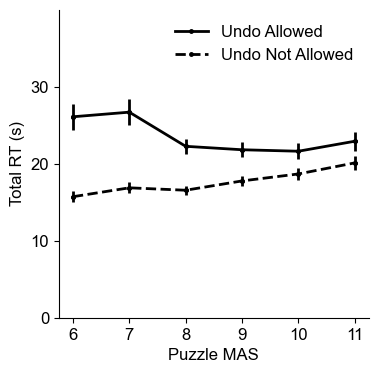

In [314]:
%matplotlib inline

# set font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(4,4))

colors = sns.color_palette("colorblind")
colors = ['0', '0']

# plot bar plot of hist_undo
plt.plot(np.arange(6), total_RT_mas_persub_undoAllowed.mean(axis=0), color=colors[0], linewidth=2, marker='.', markersize=5, label='Undo Allowed')
plt.errorbar(np.arange(6), total_RT_mas_persub_undoAllowed.mean(axis=0), yerr=total_RT_mas_persub_undoAllowed.std(axis=0)/np.sqrt(100), color=colors[0], linewidth=2, marker='.', markersize=5, label=None, linestyle='')

plt.plot(np.arange(6), np.nanmean(total_RT_mas_persub_undoNotAllowed, axis=0), color=colors[1], linewidth=2, marker='.', markersize=5, label='Undo Not Allowed', linestyle='--')
plt.errorbar(np.arange(6), np.nanmean(total_RT_mas_persub_undoNotAllowed,axis=0), yerr=total_RT_mas_persub_undoNotAllowed.std(axis=0)/np.sqrt(100), color=colors[1], linewidth=2, marker='.', markersize=5, label=None, linestyle='')


plt.xlabel('Puzzle MAS')
plt.ylabel('Total RT (s)')

# plt.legend that without box
plt.legend(frameon=False)

# delete top and right frame using plt
sns.despine()

# set ylim
plt.ylim([0, 40])

# set xticks
plt.xticks(np.arange(0,6,1), ['6','7','8','9','10','11'])

# set yticks
plt.yticks(np.arange(0,40,10))

# save figure
plt.savefig(out_dir + '/total_RT.png', dpi=300, bbox_inches='tight')
plt.show()


## error magnitude

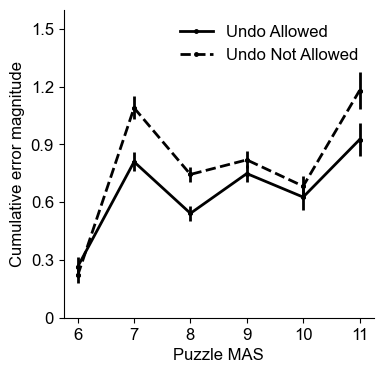

In [315]:
%matplotlib inline

# set font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(4,4))

colors = sns.color_palette("colorblind")
colors = ['0', '0']

# cumul_error_mag_mas_persub_UA = np.array(cumul_error_mag_mas_persub_UA)
# cumul_error_mag_mas_persub_UNA = np.array(cumul_error_mag_mas_persub_UNA)

# plot bar plot of hist_undo
plt.plot(np.arange(6), cumul_error_mag_mas_persub_UA.mean(axis=0), color=colors[0], linewidth=2, marker='.', markersize=5, label='Undo Allowed')
plt.errorbar(np.arange(6), cumul_error_mag_mas_persub_UA.mean(axis=0), yerr=cumul_error_mag_mas_persub_UA.std(axis=0)/np.sqrt(100), color=colors[0], linewidth=2, marker='.', markersize=5, label=None, linestyle='')

plt.plot(np.arange(6), np.nanmean(cumul_error_mag_mas_persub_UNA, axis=0), color=colors[1], linewidth=2, marker='.', markersize=5, label='Undo Not Allowed', linestyle='--')
plt.errorbar(np.arange(6), np.nanmean(cumul_error_mag_mas_persub_UNA,axis=0), yerr=cumul_error_mag_mas_persub_UNA.std(axis=0)/np.sqrt(100), color=colors[1], linewidth=2, marker='.', markersize=5, label=None, linestyle='')


plt.xlabel('Puzzle MAS')
plt.ylabel('Cumulative error magnitude')

# plt.legend that without box
plt.legend(frameon=False)

# delete top and right frame using plt
sns.despine()

# set ylim
plt.ylim([0, 1.6])
#
# set xticks
plt.xticks(np.arange(0,6,1), ['6','7','8','9','10','11'])
plt.yticks(np.arange(0,1.6,0.3), ['0','0.3','0.6','0.9','1.2','1.5'])
#
# # set yticks
# plt.yticks(np.arange(0,40,10))

# save figure
plt.savefig(out_dir + '/cumulative_error_magnitude.png', dpi=300, bbox_inches='tight')
plt.show()


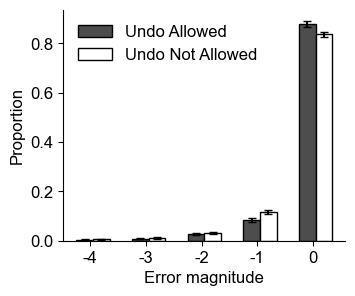

In [316]:
%matplotlib inline
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
# numpy hist for point_loss[:,0]

# plot bar plot of hist_undo
plt.bar(np.arange(-0.1,4.8,1), error_magnitude[:,:5].mean(axis=0), width=0.3, color='0.3', alpha=1, label='Undo Allowed', edgecolor='k')
# plot error bar
plt.errorbar(np.arange(-0.1,4.8,1), error_magnitude[:,:5].mean(axis=0), yerr=error_magnitude[:,:5].std(axis=0)/np.sqrt(100), fmt='none', color='k', capsize=3)

# plot bar plot of hist_basic
plt.bar(np.arange(0.2,5.2,1), error_magnitude[:,5:].mean(axis=0), width=0.3, color='1', alpha=1, label='Undo Not Allowed', edgecolor='k')
# plot error bar
plt.errorbar(np.arange(0.2,5.2,1), error_magnitude[:,5:].mean(axis=0), yerr=error_magnitude[:,5:].std(axis=0)/np.sqrt(100), fmt='none', color='k', capsize=3)


# Y label
plt.ylabel('Proportion')
# X label
plt.xlabel('Error magnitude')

# plt.legend that without box
plt.legend(frameon=False)

# delete top and right frame using plt
sns.despine()

# set xticks
plt.xticks(np.arange(0,5,1), np.arange(-4,1,1))

# save figure
plt.savefig(out_dir + '/error_magnitude.png', dpi=300, bbox_inches='tight')
plt.show()



In [317]:
# ttest_ind for error_magnitude_mean
from scipy.stats import ttest_ind, wilcoxon

stat, p = ttest_ind(error_magnitude_mean[:,0], error_magnitude_mean[:,1])
stat, p = wilcoxon(error_magnitude_mean[:,0], error_magnitude_mean[:,1])

In [318]:
print(stat)
print(p)

618.5
1.5103176165934075e-10


In [319]:
error_magnitude_mean = -error_magnitude_mean

error_magnitude_mean_didnotundo = -error_magnitude_mean_didnotundo
error_magnitude_mean_didundo = -error_magnitude_mean_didundo

optimality_firstmove = -optimality_firstmove

p = 0.000


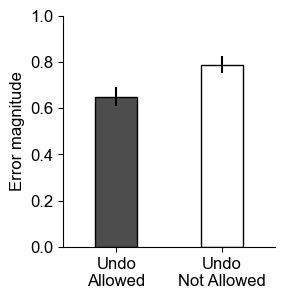

In [320]:
# plot of error magnitude
%matplotlib inline

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.bar(0, np.mean(error_magnitude_mean[:,0]), yerr=np.std(error_magnitude_mean[:,0])/np.sqrt(100), color='0.3', edgecolor = 'k', width=0.4)
plt.bar(1, np.mean(error_magnitude_mean[:,1]), yerr=np.std(error_magnitude_mean[:,1])/np.sqrt(100), color='1', edgecolor = 'k', width=0.4)

# plt.bar([0,1], np.mean(leftover, axis=0), yerr=np.std(leftover, axis=0)/np.sqrt(100),color=[.7,.7,.7], edgecolor = 'k',)
# plt.xticks([0,1], ['undo', 'basic'])
plt.xticks([0,1], ['Undo\nAllowed', 'Undo\nNot Allowed'])
# plt.title('leftover')
plt.xlim(-0.5, 1.5)

plt.ylim(0,1)

plt.ylabel('Error magnitude')

# remove top and right frame
sns.despine()

# text that says about the p value
# plt.text(0.5, 0.95, 'p = %.3f' % p, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# print p value
print('p = %.3f' % p)

# save figure
plt.savefig(out_dir + '/errormagnitude_bar.png', dpi=300, bbox_inches='tight')
plt.show()

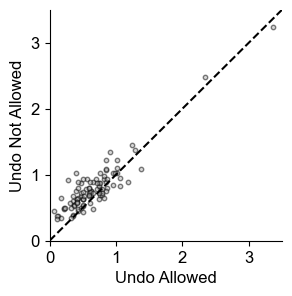

In [321]:
# scatter plot of error magnitude
%matplotlib inline
# set font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(3,3))

plt.scatter(error_magnitude_mean[:,0], error_magnitude_mean[:,1], color=[.7,.7,.7], s=10, alpha=0.5, edgecolor = 'k')

# get plausible range of x and y and set xlim and ylim
plt.xlim([0, 3.5])
plt.ylim([0, 3.5])

# set xand y label
plt.xlabel('Undo Allowed')
plt.ylabel('Undo Not Allowed')

# title
# plt.title('Error magnitude')


# remove top and right frame
sns.despine()

# mid line
plt.plot([0,3.5],[0,3.5], 'k--')

# save figure
plt.savefig(out_dir + '/scatter_error_magnitude.png', dpi=300, bbox_inches='tight')


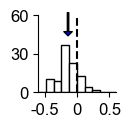

In [322]:
# small histogram around diagonal line
%matplotlib inline

plt.figure(figsize=(1,1))

plt.hist(error_magnitude_mean[:,0]-error_magnitude_mean[:,1], bins=np.linspace(-0.6,0.6,11), color='w', alpha=1, label='Undo Allowed', edgecolor='k')
# center line of histogram at x = 0
plt.plot([0,0],[0,60], 'k--')


# add downward arrow that shows the mean of the distribution
plt.annotate('', xy=(np.mean(error_magnitude_mean[:,0]-error_magnitude_mean[:,1]), 43), xytext=(np.mean(error_magnitude_mean[:,0]-error_magnitude_mean[:,1]), 63),
            arrowprops=dict(facecolor='blue', shrink=0.05, headlength=3, headwidth=6, width=1),
             )


# remove top and right frame
sns.despine()

# set x and y lim
plt.xlim([-0.6,0.6])
plt.ylim([0,60])

# set x and y ticks
plt.xticks([-0.5,0,0.5])
# set xtickslabel
plt.gca().set_xticklabels(['-0.5','0','0.5'])
plt.yticks([0,30,60])

# save figure
plt.savefig(out_dir + '/hist_error_magnitude.png', dpi=300, bbox_inches='tight')


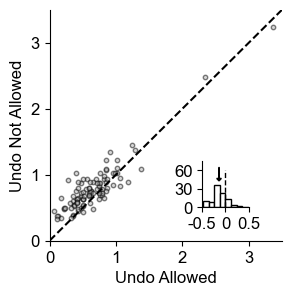

In [323]:
# scatter plot of error magnitude
%matplotlib inline
# set font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(3,3))

plt.scatter(error_magnitude_mean[:,0], error_magnitude_mean[:,1], color=[.7,.7,.7], s=10, alpha=0.5, edgecolor = 'k')

# get plausible range of x and y and set xlim and ylim
plt.xlim([0, 3.5])
plt.ylim([0, 3.5])

# set xand y label
plt.xlabel('Undo Allowed')
plt.ylabel('Undo Not Allowed')

# title
# plt.title('Error magnitude')


# remove top and right frame
sns.despine()

# mid line
plt.plot([0,3.5],[0,3.5], 'k--')
# make inset and include hist_error_magnitude
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(plt.gca(), width="20%", height="20%", loc=4, borderpad=2)
axins.hist(error_magnitude_mean[:,0]-error_magnitude_mean[:,1], bins=np.linspace(-0.6,0.6,11), color='w', alpha=1, label='Undo Allowed', edgecolor='k')
# center line of histogram at x = 0
axins.plot([0,0],[0,60], 'k--', linewidth=1)

# add downward arrow that shows the mean of the distribution
axins.arrow(np.mean(error_magnitude_mean[:,0]-error_magnitude_mean[:,1]), 65, 0, -18, head_width=2/20, head_length=4, fc='k', ec='k')

# set x and y lim of axins
axins.set_xlim([-0.5,0.5])
axins.set_ylim([0,75])

# set x and y ticks of axins
axins.set_xticks([-0.5,0,0.5])

# set xtickslabel of axins
axins.set_xticklabels(['-0.5','0','0.5'])
axins.set_yticks([0,30,60])


# remove top and right frame
sns.despine()

# save figure
plt.savefig(out_dir + '/scatter_error_magnitude_inset.png', dpi=300, bbox_inches='tight')


### error magnitude but where people undid

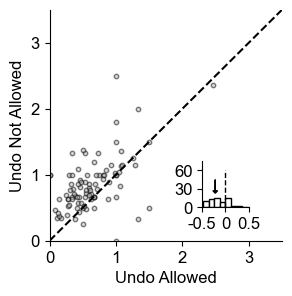

In [324]:
# scatter plot of time taken
%matplotlib inline
# set font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(3,3))

# index that is not nan
index_not_nan = np.logical_not(np.isnan(error_magnitude_mean_didundo[:,0]))

plt.scatter(error_magnitude_mean_didundo[index_not_nan,0], error_magnitude_mean_didundo[index_not_nan,1], color=[.7,.7,.7], s=10, alpha=0.5, edgecolor = 'k')

# get plausible range of x and y and set xlim and ylim
plt.xlim([0, 3.5])
plt.ylim([0, 3.5])

# set xand y label
plt.xlabel('Undo Allowed')
plt.ylabel('Undo Not Allowed')

# title
# plt.title('Error magnitude')


# remove top and right frame
sns.despine()

# mid line
plt.plot([0,3.5],[0,3.5], 'k--')
# make inset and include hist_error_magnitude
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(plt.gca(), width="20%", height="20%", loc=4, borderpad=2)
axins.hist(error_magnitude_mean_didundo[index_not_nan,0]-error_magnitude_mean_didundo[index_not_nan,1], bins=np.linspace(-0.6,0.6,11), color='w', alpha=1, label='Undo Allowed', edgecolor='k')
# center line of histogram at x = 0
axins.plot([0,0],[0,60], 'k--', linewidth=1)

# add downward arrow that shows the mean of the distribution
axins.arrow(np.mean(error_magnitude_mean_didundo[index_not_nan,0]-error_magnitude_mean_didundo[index_not_nan,1]), 45, 0, -18, head_width=2/20, head_length=4, fc='k', ec='k')

# set x and y lim of axins
axins.set_xlim([-0.5,0.5])
axins.set_ylim([0,75])

# set x and y ticks of axins
axins.set_xticks([-0.5,0,0.5])

# set xtickslabel of axins
axins.set_xticklabels(['-0.5','0','0.5'])
axins.set_yticks([0,30,60])


# remove top and right frame
sns.despine()

# save figure
plt.savefig(out_dir + '/scatter_error_magnitude_mean_didundo_inset.png', dpi=300, bbox_inches='tight')


### error magnitude but where people did not undo

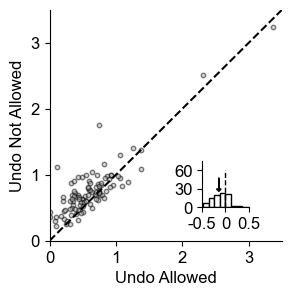

In [325]:
# scatter plot of time taken
%matplotlib inline
# set font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(3,3))

# index that is not nan
index_not_nan = np.logical_not(np.isnan(error_magnitude_mean_didnotundo[:,0]))

plt.scatter(error_magnitude_mean_didnotundo[index_not_nan,0], error_magnitude_mean_didnotundo[index_not_nan,1], color=[.7,.7,.7], s=10, alpha=0.5, edgecolor = 'k')

# get plausible range of x and y and set xlim and ylim
plt.xlim([0, 3.5])
plt.ylim([0, 3.5])

# set xand y label
plt.xlabel('Undo Allowed')
plt.ylabel('Undo Not Allowed')

# title
# plt.title('Error magnitude')


# remove top and right frame
sns.despine()

# mid line
plt.plot([0,3.5],[0,3.5], 'k--')
# make inset and include hist_error_magnitude
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(plt.gca(), width="20%", height="20%", loc=4, borderpad=2)
axins.hist(error_magnitude_mean_didnotundo[index_not_nan,0]-error_magnitude_mean_didnotundo[index_not_nan,1], bins=np.linspace(-0.6,0.6,11), color='w', alpha=1, label='Undo Allowed', edgecolor='k')
# center line of histogram at x = 0
axins.plot([0,0],[0,60], 'k--', linewidth=1)

# add downward arrow that shows the mean of the distribution
axins.arrow(np.mean(error_magnitude_mean_didnotundo[index_not_nan,0]-error_magnitude_mean_didnotundo[index_not_nan,1]), 48, 0, -18, head_width=2/20, head_length=4, fc='k', ec='k')

# set x and y lim of axins
axins.set_xlim([-0.5,0.5])
axins.set_ylim([0,75])

# set x and y ticks of axins
axins.set_xticks([-0.5,0,0.5])

# set xtickslabel of axins
axins.set_xticklabels(['-0.5','0','0.5'])
axins.set_yticks([0,30,60])


# remove top and right frame
sns.despine()

# save figure
plt.savefig(out_dir + '/scatter_error_magnitude_mean_didnotundo_inset.png', dpi=300, bbox_inches='tight')


## Optimality first move

In [326]:
# statistical test for optimality_firstmove
from scipy.stats import wilcoxon
print(np.mean(optimality_firstmove[:,0]) - np.mean(optimality_firstmove[:,1]))
stat, p = wilcoxon(optimality_firstmove[:,0], optimality_firstmove[:,1])
print(stat, p)

0.010869565217391353
1842.0 0.3203054024300318


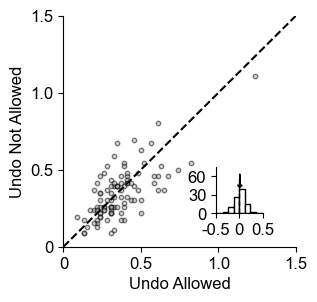

In [327]:
# scatter plot
%matplotlib inline
# set font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(3,3))

# index that is not nan
index_not_nan = np.logical_not(np.isnan(optimality_firstmove[:,0]))

plt.scatter(optimality_firstmove[index_not_nan,0], optimality_firstmove[index_not_nan,1], color=[.7,.7,.7], s=10, alpha=0.5, edgecolor = 'k')

# get plausible range of x and y and set xlim and ylim
plt.xlim([0, 1.5])
plt.ylim([0, 1.5])

# set xand y label
plt.xlabel('Undo Allowed')
plt.ylabel('Undo Not Allowed')

# set xticks and yticks
plt.xticks([0,0.5,1,1.5], ['0','0.5','1.0','1.5'])
plt.yticks([0,0.5,1,1.5], ['0','0.5','1.0','1.5'])

# title
# plt.title('Error magnitude')


# remove top and right frame
sns.despine()

# mid line
plt.plot([0,1.5],[0,1.5], 'k--')
# make inset and include hist_error_magnitude
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(plt.gca(), width="20%", height="20%", loc=4, borderpad=2)
axins.hist(optimality_firstmove[index_not_nan,0]-optimality_firstmove[index_not_nan,1], bins=np.linspace(-0.6,0.6,11), color='w', alpha=1, label='Undo Allowed', edgecolor='k')
# center line of histogram at x = 0
axins.plot([0,0],[0,60], 'k--', linewidth=1)

# add downward arrow that shows the mean of the distribution
axins.arrow(np.mean(optimality_firstmove[index_not_nan,0]-optimality_firstmove[index_not_nan,1]), 64, 0, -18, head_width=2/20, head_length=4, fc='k', ec='k')

# set x and y lim of axins
axins.set_xlim([-0.5,0.5])
axins.set_ylim([0,75])

# set x and y ticks of axins
axins.set_xticks([-0.5,0,0.5])

# set xtickslabel of axins
axins.set_xticklabels(['-0.5','0','0.5'])
axins.set_yticks([0,30,60])


# remove top and right frame
sns.despine()

# save figure
plt.savefig(out_dir + '/scatter_optimality_firstmove_inset.png', dpi=300, bbox_inches='tight')


## leftover

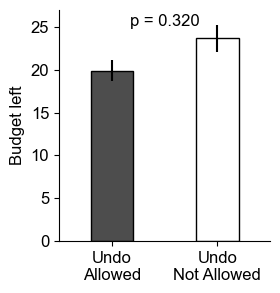

In [328]:
# plot of leftover
%matplotlib inline

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.bar(0, np.mean(leftover[:,0]), yerr=np.std(leftover[:,0])/np.sqrt(100), color='0.3', edgecolor = 'k', width=0.4)
plt.bar(1, np.mean(leftover[:,1]), yerr=np.std(leftover[:,1])/np.sqrt(100), color='1', edgecolor = 'k', width=0.4)

# plt.bar([0,1], np.mean(leftover, axis=0), yerr=np.std(leftover, axis=0)/np.sqrt(100),color=[.7,.7,.7], edgecolor = 'k',)
# plt.xticks([0,1], ['undo', 'basic'])
plt.xticks([0,1], ['Undo\nAllowed', 'Undo\nNot Allowed'])
# plt.title('leftover')
plt.xlim(-0.5, 1.5)

plt.ylim(0,27)

plt.ylabel('Budget left')

# remove top and right frame
sns.despine()

# text that says about the p value
plt.text(0.5, 0.95, 'p = %.3f' % p, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)


# save figure
plt.savefig(out_dir + '/leftover_bar.png', dpi=300, bbox_inches='tight')
plt.show()

In [329]:
# statistical test for leftover
from scipy.stats import wilcoxon
stat, p = wilcoxon(leftover[:,0], leftover[:,1])
print(stat, p)
# print mean difference
print(np.mean(leftover[:,0]) - np.mean(leftover[:,1]))

380.0 1.6409015596347118e-13
-3.7683631458328257


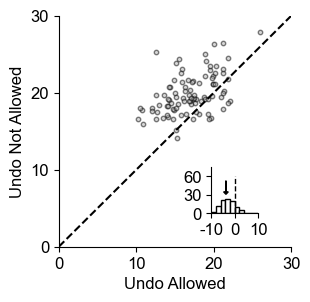

In [330]:
%matplotlib inline
# set font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(3,3))

plt.scatter(leftover[:,0], leftover[:,1], color=[.7,.7,.7], s=10, alpha=0.5, edgecolor = 'k')

# get plausible range of x and y and set xlim and ylim
plt.xlim([0, 27])
plt.ylim([0, 27])

# set xand y label
plt.xlabel('Undo Allowed')
plt.ylabel('Undo Not Allowed')

# title
# plt.title('Error magnitude')


# remove top and right frame
sns.despine()

# mid line
plt.plot([0,30],[0,30], 'k--')

# set xticks and yticks
plt.xticks([0,10,20,30])
plt.yticks([0,10,20,30])

# make inset and include hist_error_magnitude
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(plt.gca(), width="20%", height="20%", loc=4, borderpad=2)
axins.hist(leftover[:,0]-leftover[:,1], bins=np.linspace(-10,10,11), color='w', alpha=1, label='Undo Allowed', edgecolor='k')
# center line of histogram at x = 0
axins.plot([0,0],[0,60], 'k--', linewidth=1)

# add downward arrow that shows the mean of the distribution
axins.arrow(np.mean(leftover[:,0]-leftover[:,1]), 53, 0, -18, head_width=2, head_length=4, fc='k', ec='k')

# set x and y lim of axins
axins.set_xlim([-10,10])
axins.set_ylim([0,75])

# set x and y ticks of axins
axins.set_xticks([-10,0,10])

# set xtickslabel of axins
axins.set_xticklabels(['-10','0','10'])
axins.set_yticks([0,30,60])


# remove top and right frame
sns.despine()

# save figure
plt.savefig(out_dir + '/scatter_leftover_inset.png', dpi=300, bbox_inches='tight')


## RTs

In [331]:
undo_level = data_choice_level[data_choice_level['condition']==1].copy().reset_index()
basic_level = data_choice_level[data_choice_level['condition']==0].copy().reset_index()

time_taken =[]
first_RT = []

firstMove_RTs_per_MAS = []
laterMove_RTs_per_MAS = []


firstMove_RTs_per_MAS_UNA = []
laterMove_RTs_per_MAS_UNA = []


for sub in range(100):

    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    dat_sbj_undo  = undo_level[undo_level['subjects']==sub].sort_values(["puzzleID","index"])
    dat_sbj_basic  = basic_level[basic_level['subjects']==sub].sort_values(["puzzleID","index"])

    time_taken_puzzle = []
    first_RT_puzzle = []

    firstMove_RTs_per_MAS_puzzle = []
    laterMove_RTs_per_MAS_puzzle = []

    firstMove_RTs_per_MAS_puzzle_UNA = []
    laterMove_RTs_per_MAS_puzzle_UNA = []

    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID']==pzi]
        dat_sbj_undo_pzi = dat_sbj_undo[dat_sbj_undo['puzzleID']==pzi]
        dat_sbj_basic_pzi = dat_sbj_basic[dat_sbj_basic['puzzleID']==pzi]

        time_taken_puzzle.append([np.sum(dat_sbj_undo_pzi['RT'][1:])+np.sum(dat_sbj_undo_pzi['undoRT']), np.sum(dat_sbj_basic_pzi['RT'][1:]) ])
        first_RT_puzzle.append([(dat_sbj_undo_pzi['RT'].iloc[1]), (dat_sbj_basic_pzi['RT'].iloc[1]) ])

        # firstmove RTs
        firstMove_RTs_per_MAS_puzzle.append([np.array(dat_sbj_undo_pzi['RT'])[1], dat_sbj_undo_pzi['currMas'].iloc[0]])
        # index of move that is not undo
        idx_not_undo = np.where(dat_sbj_undo_pzi['undo']==0)[0]
        laterMove_RTs_per_MAS_puzzle.append([np.mean(np.array(dat_sbj_undo_pzi['RT'])[idx_not_undo[1:]]), dat_sbj_undo_pzi['currMas'].iloc[0]])

        # firstmove RTs in undo not allowed
        firstMove_RTs_per_MAS_puzzle_UNA.append([np.array(dat_sbj_basic_pzi['RT'])[1], dat_sbj_basic_pzi['currMas'].iloc[0]])
        # index of move that is not undo
        idx_not_undo = np.where(dat_sbj_basic_pzi['undo']==0)[0]
        laterMove_RTs_per_MAS_puzzle_UNA.append([np.mean(np.array(dat_sbj_basic_pzi['RT'])[idx_not_undo[1:]]), dat_sbj_basic_pzi['currMas'].iloc[0]])

    time_taken.append(time_taken_puzzle)
    first_RT.append(first_RT_puzzle)

    firstMove_RTs_per_MAS.append(firstMove_RTs_per_MAS_puzzle)
    laterMove_RTs_per_MAS.append(laterMove_RTs_per_MAS_puzzle)

    firstMove_RTs_per_MAS_UNA.append(firstMove_RTs_per_MAS_puzzle_UNA)
    laterMove_RTs_per_MAS_UNA.append(laterMove_RTs_per_MAS_puzzle_UNA)

time_taken = np.array(time_taken)
first_RT = np.array(first_RT)

firstMove_RTs_per_MAS = np.array(firstMove_RTs_per_MAS)
laterMove_RTs_per_MAS = np.array(laterMove_RTs_per_MAS)

firstMove_RTs_per_MAS_UNA = np.array(firstMove_RTs_per_MAS_UNA)
laterMove_RTs_per_MAS_UNA = np.array(laterMove_RTs_per_MAS_UNA)

In [332]:
first_move_RT_vs_puzzleMAS = []
later_move_RT_vs_puzzleMAS = []

first_move_RT_vs_puzzleMAS_UNA = []
later_move_RT_vs_puzzleMAS_UNA = []

for sub in range(100):
    first_move_RT_vs_puzzleMAS_sub = []
    later_move_RT_vs_puzzleMAS_sub = []

    first_move_RT_vs_puzzleMAS_sub_UNA = []
    later_move_RT_vs_puzzleMAS_sub_UNA = []
    for j in range(7,13):
        first_move_RT_vs_puzzleMAS_sub.append(firstMove_RTs_per_MAS[sub,firstMove_RTs_per_MAS[sub,:,1] == j,0].mean())
        later_move_RT_vs_puzzleMAS_sub.append(laterMove_RTs_per_MAS[sub,laterMove_RTs_per_MAS[sub,:,1] == j,0].mean())

        first_move_RT_vs_puzzleMAS_sub_UNA.append(firstMove_RTs_per_MAS_UNA[sub,firstMove_RTs_per_MAS_UNA[sub,:,1] == j,0].mean())
        later_move_RT_vs_puzzleMAS_sub_UNA.append(laterMove_RTs_per_MAS_UNA[sub,laterMove_RTs_per_MAS_UNA[sub,:,1] == j,0].mean())
    first_move_RT_vs_puzzleMAS.append(first_move_RT_vs_puzzleMAS_sub)
    later_move_RT_vs_puzzleMAS.append(later_move_RT_vs_puzzleMAS_sub)

    first_move_RT_vs_puzzleMAS_UNA.append(first_move_RT_vs_puzzleMAS_sub_UNA)
    later_move_RT_vs_puzzleMAS_UNA.append(later_move_RT_vs_puzzleMAS_sub_UNA)
first_move_RT_vs_puzzleMAS = np.array(first_move_RT_vs_puzzleMAS)/1000
later_move_RT_vs_puzzleMAS = np.array(later_move_RT_vs_puzzleMAS)/1000

first_move_RT_vs_puzzleMAS_UNA = np.array(first_move_RT_vs_puzzleMAS_UNA)/1000
later_move_RT_vs_puzzleMAS_UNA = np.array(later_move_RT_vs_puzzleMAS_UNA)/1000

## time taken

In [333]:
time_taken_ = np.array(time_taken).reshape((-1,2))/1000

In [334]:
# ttest_ind
from scipy.stats import ttest_ind
stat,p=ttest_ind(time_taken_[:,0], time_taken_[:,1])
print('stat=%.3f, p=%.3f' % (stat, p))

stat=20.330, p=0.000


stat=20.330, p=0.000


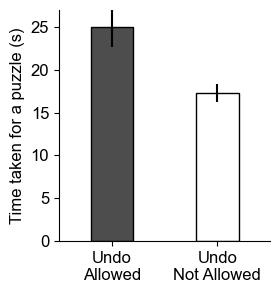

In [335]:
# bar plot
%matplotlib inline


plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.bar(0, np.mean(time_taken_[:,0]), yerr=np.std(time_taken_[:,0])/np.sqrt(100), color='0.3', edgecolor = 'k', width=0.4)
plt.bar(1, np.mean(time_taken_[:,1]), yerr=np.std(time_taken_[:,1])/np.sqrt(100), color='1', edgecolor = 'k', width=0.4)

# plt.bar([0,1], np.mean(leftover, axis=0), yerr=np.std(leftover, axis=0)/np.sqrt(100),color=[.7,.7,.7], edgecolor = 'k',)
# plt.xticks([0,1], ['undo', 'basic'])
plt.xticks([0,1], ['Undo\nAllowed', 'Undo\nNot Allowed'])
# plt.title('leftover')
plt.xlim(-0.5, 1.5)

plt.ylim(0,27)

plt.ylabel('Time taken for a puzzle (s)')

#statistical test
from scipy.stats import ttest_ind
stat,p=ttest_ind(time_taken_[:,0], time_taken_[:,1])
print('stat=%.3f, p=%.3f' % (stat, p))

# text that says about the p value
# plt.text(0.5, 0.95, 'p = %.3f' % p, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)


# remove top and right frame
sns.despine()

# save figure
plt.savefig(out_dir + '/time_taken_bar.png', dpi=300, bbox_inches='tight')

# save figure
plt.show()

In [336]:
time_taken_mean = time_taken.mean(axis=1)/1000

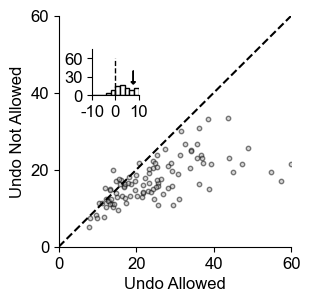

In [337]:
%matplotlib inline
# set font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(3,3))

plt.scatter(time_taken_mean[:,0], time_taken_mean[:,1], color=[.7,.7,.7], s=10, alpha=0.5, edgecolor = 'k')

# get plausible range of x and y and set xlim and ylim
plt.xlim([0, 27])
plt.ylim([0, 27])

# set xand y label
plt.xlabel('Undo Allowed')
plt.ylabel('Undo Not Allowed')

# title
# plt.title('Error magnitude')


# remove top and right frame
sns.despine()

# mid line
plt.plot([0,60],[0,60], 'k--')

# set xticks and yticks
plt.xticks([0,20,40,60])
plt.yticks([0,20,40,60])

# make inset and include hist_error_magnitude
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(plt.gca(), width="20%", height="20%", loc=2, borderpad=2)
axins.hist(time_taken_mean[:,0]-time_taken_mean[:,1], bins=np.linspace(-10,10,11), color='w', alpha=1, label='Undo Allowed', edgecolor='k')
# center line of histogram at x = 0
axins.plot([0,0],[0,60], 'k--', linewidth=1)


# add downward arrow that shows the mean of the distribution
axins.arrow(np.mean(time_taken_mean[:,0]-time_taken_mean[:,1]), 40, 0, -18, head_width=2, head_length=4, fc='k', ec='k')

# set x and y lim of axins
axins.set_xlim([-10,10])
axins.set_ylim([0,75])

# set x and y ticks of axins
axins.set_xticks([-10,0,10])

# set xtickslabel of axins
axins.set_xticklabels(['-10','0','10'])
axins.set_yticks([0,30,60])


# remove top and right frame
sns.despine()

# save figure
plt.savefig(out_dir + '/scatter_time_taken_inset.png', dpi=300, bbox_inches='tight')


## first RT

In [338]:
first_RT_ = np.array(first_RT).reshape((-1,2))/1000

In [339]:
# ttest_ind
from scipy.stats import ttest_ind
stat,p=ttest_ind(first_RT_[:,0], first_RT_[:,1])
print('stat=%.3f, p=%.3f' % (stat, p))


stat=-5.825, p=0.000


stat=-5.825, p=0.000


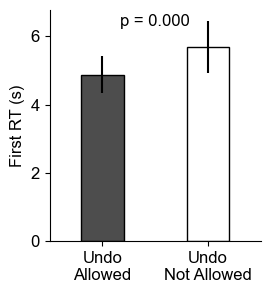

In [340]:
# bar plot
%matplotlib inline


plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.bar(0, np.mean(first_RT_[:,0]), yerr=np.std(first_RT_[:,0])/np.sqrt(100), color='0.3', edgecolor = 'k', width=0.4)
plt.bar(1, np.mean(first_RT_[:,1]), yerr=np.std(first_RT_[:,1])/np.sqrt(100), color='1', edgecolor = 'k', width=0.4)

# plt.bar([0,1], np.mean(leftover, axis=0), yerr=np.std(leftover, axis=0)/np.sqrt(100),color=[.7,.7,.7], edgecolor = 'k',)
# plt.xticks([0,1], ['undo', 'basic'])
plt.xticks([0,1], ['Undo\nAllowed', 'Undo\nNot Allowed'])
# plt.title('leftover')
plt.xlim(-0.5, 1.5)


plt.ylabel('First RT (s)')

#statistical test
from scipy.stats import ttest_ind
stat,p=ttest_ind(first_RT_[:,0], first_RT_[:,1])
print('stat=%.3f, p=%.3f' % (stat, p))


# remove top and right frame
sns.despine()

# text that says about the p value
plt.text(0.5, 0.95, 'p = %.3f' % p, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

# save figure
plt.savefig(out_dir + '/bar_first_RT.png', dpi=300, bbox_inches='tight')
# save figure
plt.show()

In [341]:
first_RT_mean = np.mean(first_RT, axis=1)/1000

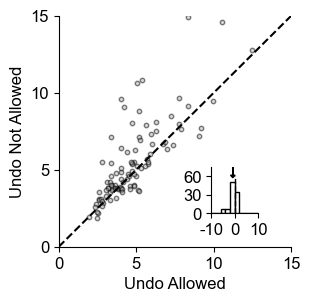

In [342]:
# scatter plot of time taken
%matplotlib inline
# set font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(3,3))

plt.scatter(first_RT_mean[:,0], first_RT_mean[:,1], color=[.7,.7,.7], s=10, alpha=0.5, edgecolor = 'k')

# get plausible range of x and y and set xlim and ylim
plt.xlim([0, 15])
plt.ylim([0, 15])

# set xand y label
plt.xlabel('Undo Allowed')
plt.ylabel('Undo Not Allowed')

# title
# plt.title('Error magnitude')


# remove top and right frame
sns.despine()

# mid line
plt.plot([0,15],[0,15], 'k--')

# set xticks and yticks
plt.xticks([0,5,10,15])
plt.yticks([0,5,10,15])

# make inset and include hist_error_magnitude
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(plt.gca(), width="20%", height="20%", loc=4, borderpad=2)
axins.hist(first_RT_mean[:,0]-first_RT_mean[:,1], bins=np.linspace(-10,10,11), color='w', alpha=1, label='Undo Allowed', edgecolor='k')
# center line of histogram at x = 0
axins.plot([0,0],[0,60], 'k--', linewidth=1)

# add downward arrow that shows the mean of the distribution
axins.arrow(np.mean(first_RT_mean[:,0]-first_RT_mean[:,1]), 80, 0, -18, head_width=2, head_length=4, fc='k', ec='k')

# set x and y lim of axins
axins.set_xlim([-10,10])
axins.set_ylim([0,75])

# set x and y ticks of axins
axins.set_xticks([-10,0,10])

# set xtickslabel of axins
axins.set_xticklabels(['-10','0','10'])
axins.set_yticks([0,30,60])


# remove top and right frame
sns.despine()

# save figure
plt.savefig(out_dir + '/scatter_firstRTmean_inset.png', dpi=300, bbox_inches='tight')


## Average first-move RT & Average layer-move RT versus puzzle MAS

In [343]:
np.std(first_move_RT_vs_puzzleMAS, axis=0)/np.sqrt(100)

array([0.33355858, 0.48090301, 0.21692447, 0.22047814, 0.25347762,
       0.65977468])

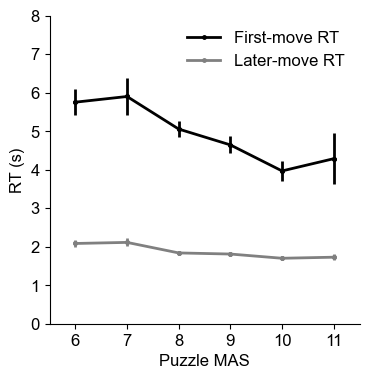

In [344]:
%matplotlib inline

# set font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(4,4))

# get two colors distinguishable for who cannot see red and green
colors= ['0', '0.5']

# line plot with error bar for average first-move RT
plt.plot(np.arange(6), np.mean(first_move_RT_vs_puzzleMAS, axis=0), color=colors[0], linewidth=2, marker='.', markersize=5, label='First-move RT')
plt.errorbar(np.arange(6), np.mean(first_move_RT_vs_puzzleMAS, axis=0), yerr=np.std(first_move_RT_vs_puzzleMAS, axis=0)/np.sqrt(100), color=colors[0], linewidth=2, marker='.', markersize=5, label=None, linestyle='')
# line plot with error bar for average layer-move RT but in dashed line
plt.plot(np.arange(6), np.mean(later_move_RT_vs_puzzleMAS, axis=0), color=colors[1], linewidth=2, marker='.', markersize=5, label='Later-move RT')
plt.errorbar(np.arange(6), np.mean(later_move_RT_vs_puzzleMAS, axis=0), yerr=np.std(later_move_RT_vs_puzzleMAS, axis=0)/np.sqrt(100), color=colors[1], linewidth=2, marker='.', markersize=5, label=None, linestyle='')

# set x and y lim
plt.xlim([-0.5, 5.5])
plt.ylim([0, 8])

sns.despine()

# set xticks
plt.xticks(np.arange(6), ['6', '7', '8', '9', '10', '11'])

# set x and y label
plt.xlabel('Puzzle MAS')
plt.ylabel('RT (s)')

# set legend
plt.legend(loc='upper right', frameon=False)

# save figure
plt.savefig(out_dir + '/line_first_move_RT_later_move_RT_vs_puzzleMAS.png', dpi=300, bbox_inches='tight')


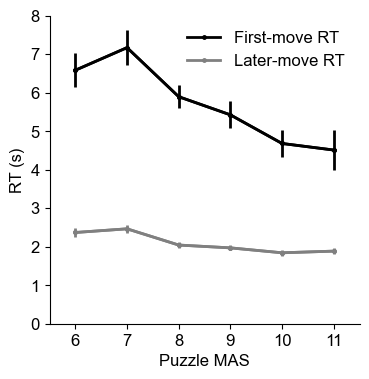

In [345]:
%matplotlib inline

# set font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(4,4))

# get two colors distinguishable for who cannot see red and green
colors= ['0', '0.5']

# line plot with error bar for average first-move RT
plt.plot(np.arange(6), np.mean(first_move_RT_vs_puzzleMAS_UNA, axis=0), color=colors[0], linewidth=2, marker='.', markersize=5, label='First-move RT')
plt.errorbar(np.arange(6), np.mean(first_move_RT_vs_puzzleMAS_UNA, axis=0), yerr=np.std(first_move_RT_vs_puzzleMAS_UNA, axis=0)/np.sqrt(100), color=colors[0], linewidth=2, marker='.', markersize=5, label=None)
# line plot with error bar for average layer-move RT
plt.plot(np.arange(6), np.mean(later_move_RT_vs_puzzleMAS_UNA, axis=0), color=colors[1], linewidth=2, marker='.', markersize=5, label='Later-move RT')
plt.errorbar(np.arange(6), np.mean(later_move_RT_vs_puzzleMAS_UNA, axis=0), yerr=np.std(later_move_RT_vs_puzzleMAS_UNA, axis=0)/np.sqrt(100), color=colors[1], linewidth=2, marker='.', markersize=5, label=None)

# set x and y lim
plt.xlim([-0.5, 5.5])
plt.ylim([0, 8])

sns.despine()

# set xticks
plt.xticks(np.arange(6), ['6', '7', '8', '9', '10', '11'])

# set x and y label
plt.xlabel('Puzzle MAS')
plt.ylabel('RT (s)')

# set legend
plt.legend(loc='upper right', frameon=False)

# save figure
plt.savefig(out_dir + '/line_first_move_RT_later_move_RT_vs_puzzleMAS_UNA.png', dpi=300, bbox_inches='tight')


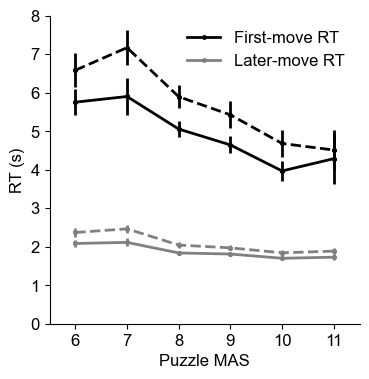

In [346]:
# in one figure
%matplotlib inline

# set font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(4,4))

# get two colors distinguishable for who cannot see red and green
colors= ['0', '0.5']

# line plot with error bar for average first-move RT
plt.plot(np.arange(6), np.mean(first_move_RT_vs_puzzleMAS, axis=0), color=colors[0], linewidth=2, marker='.', markersize=5, label='First-move RT')
plt.errorbar(np.arange(6), np.mean(first_move_RT_vs_puzzleMAS, axis=0), yerr=np.std(first_move_RT_vs_puzzleMAS, axis=0)/np.sqrt(100), color=colors[0], linewidth=2, marker='.', markersize=5, label=None, linestyle='')
# line plot with error bar for average layer-move RT but in dashed line
plt.plot(np.arange(6), np.mean(later_move_RT_vs_puzzleMAS, axis=0), color=colors[1], linewidth=2, marker='.', markersize=5, label='Later-move RT')
plt.errorbar(np.arange(6), np.mean(later_move_RT_vs_puzzleMAS, axis=0), yerr=np.std(later_move_RT_vs_puzzleMAS, axis=0)/np.sqrt(100), color=colors[1], linewidth=2, marker='.', markersize=5, label=None, linestyle='')



# line plot with error bar for average first-move RT
plt.plot(np.arange(6), np.mean(first_move_RT_vs_puzzleMAS_UNA, axis=0), color=colors[0], linewidth=2, marker='.', markersize=5, linestyle='--')
plt.errorbar(np.arange(6), np.mean(first_move_RT_vs_puzzleMAS_UNA, axis=0), yerr=np.std(first_move_RT_vs_puzzleMAS_UNA, axis=0)/np.sqrt(100), color=colors[0], linewidth=2, marker='.', markersize=5, label=None, linestyle='')
# line plot with error bar for average layer-move RT
plt.plot(np.arange(6), np.mean(later_move_RT_vs_puzzleMAS_UNA, axis=0), color=colors[1], linewidth=2, marker='.', markersize=5, linestyle='--')
plt.errorbar(np.arange(6), np.mean(later_move_RT_vs_puzzleMAS_UNA, axis=0), yerr=np.std(later_move_RT_vs_puzzleMAS_UNA, axis=0)/np.sqrt(100), color=colors[1], linewidth=2, marker='.', markersize=5, label=None, linestyle='')



# set x and y lim
plt.xlim([-0.5, 5.5])
plt.ylim([0, 8])

sns.despine()

# set xticks
plt.xticks(np.arange(6), ['6', '7', '8', '9', '10', '11'])

# set x and y label
plt.xlabel('Puzzle MAS')
plt.ylabel('RT (s)')

# set legend
plt.legend(loc='upper right', frameon=False)

# save figure
plt.savefig(out_dir + '/line_first_move_RT_later_move_RT_vs_puzzleMAS.png', dpi=300, bbox_inches='tight')



## calculate time for a puzzle that is matched

In [347]:
undo_level = data_choice_level[data_choice_level['condition'] == 1].copy().reset_index()
basic_level = data_choice_level[data_choice_level['condition'] == 0].copy().reset_index()

time_taken_0undo = []
first_RT_0undo = []

for sub in range(100):

    dat_sbj = sc_data_choice_level[sc_data_choice_level['subjects'] == sub].sort_values(["puzzleID", "index"])
    dat_sbj_undo = undo_level[undo_level['subjects'] == sub].sort_values(["puzzleID", "index"])
    dat_sbj_basic = basic_level[basic_level['subjects'] == sub].sort_values(["puzzleID", "index"])

    time_taken_0undo_puzzle = []
    first_RT_0undo_puzzle = []

    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi]
        dat_sbj_undo_pzi = dat_sbj_undo[dat_sbj_undo['puzzleID'] == pzi]
        dat_sbj_basic_pzi = dat_sbj_basic[dat_sbj_basic['puzzleID'] == pzi]

        # check if dat_sbj_pzi['undo'].sum() is 0
        if dat_sbj_pzi['undo'].sum() == 0:
            time_taken_0undo_puzzle.append([np.sum(dat_sbj_undo_pzi['RT'][1:])/1000, np.sum(dat_sbj_basic_pzi['RT'][1:])/1000])
            first_RT_0undo_puzzle.append([(dat_sbj_undo_pzi['RT'].iloc[1])/1000, (dat_sbj_basic_pzi['RT'].iloc[1])/1000])
        else:
            #append nan
            time_taken_0undo_puzzle.append([np.nan, np.nan])
            first_RT_0undo_puzzle.append([np.nan, np.nan])

    time_taken_0undo.append(np.nanmean(time_taken_0undo_puzzle, axis=0))
    first_RT_0undo.append(np.nanmean(first_RT_0undo_puzzle, axis=0))

time_taken_0undo = np.array(time_taken_0undo)
first_RT_0undo = np.array(first_RT_0undo)


/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_46840/2722325208.py:30: RuntimeWarning: Mean of empty slice
  time_taken_0undo.append(np.nanmean(time_taken_0undo_puzzle, axis=0))
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_46840/2722325208.py:31: RuntimeWarning: Mean of empty slice
  first_RT_0undo.append(np.nanmean(first_RT_0undo_puzzle, axis=0))


In [348]:
# statistical test
# find index that are not nan
idx_not_nan = np.where(~np.isnan(time_taken_0undo[:,0]))[0]
stat, p = wilcoxon(time_taken_0undo[idx_not_nan,0], time_taken_0undo[idx_not_nan,1])
print('Wilcoxon signed-rank test: z = %.3f, p = %.3f' % (stat, p))
# print nanmean of time_taken_0undo
print('Mean time taken for undo allowed: %.3f' % np.nanmean(time_taken_0undo[:,0]))
print('Mean time taken for undo not allowed: %.3f' % np.nanmean(time_taken_0undo[:,1]))

# print mean diff
print('Mean diff: %.3f' % np.nanmean(time_taken_0undo[:,0] - time_taken_0undo[:,1]))

Wilcoxon signed-rank test: z = 1456.000, p = 0.000
Mean time taken for undo allowed: 16.403
Mean time taken for undo not allowed: 17.320
Mean diff: -0.917


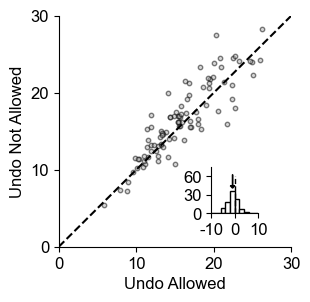

In [349]:
%matplotlib inline
# set font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(3,3))

plt.scatter(time_taken_0undo[:,0], time_taken_0undo[:,1], color=[.7,.7,.7], s=10, alpha=0.5, edgecolor = 'k')

# get plausible range of x and y and set xlim and ylim
plt.xlim([0, 27])
plt.ylim([0, 27])

# set xand y label
plt.xlabel('Undo Allowed')
plt.ylabel('Undo Not Allowed')

# title
# plt.title('Error magnitude')


# remove top and right frame
sns.despine()

# mid line
plt.plot([0,30],[0,30], 'k--')

# set xticks and yticks
plt.xticks([0,10,20,30])
plt.yticks([0,10,20,30])

# make inset and include hist_error_magnitude
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(plt.gca(), width="20%", height="20%", loc=4, borderpad=2)
axins.hist(time_taken_0undo[:,0]-time_taken_0undo[:,1], bins=np.linspace(-10,10,11), color='w', alpha=1, label='Undo Allowed', edgecolor='k')
# center line of histogram at x = 0
axins.plot([0,0],[0,60], 'k--', linewidth=1)

# add downward arrow that shows the mean of the distribution
axins.arrow(np.nanmean(time_taken_0undo[:,0]-time_taken_0undo[:,1]), 63, 0, -18, head_width=2, head_length=4, fc='k', ec='k')

# set x and y lim of axins
axins.set_xlim([-10,10])
axins.set_ylim([0,75])

# set x and y ticks of axins
axins.set_xticks([-10,0,10])

# set xtickslabel of axins
axins.set_xticklabels(['-10','0','10'])
axins.set_yticks([0,30,60])


# remove top and right frame
sns.despine()

# save figure
plt.savefig(out_dir + '/scatter_time_taken_0undo_inset.png', dpi=300, bbox_inches='tight')


# Whisker plot with pairwise comparison

(undo not allowed / undo allowed) x (full / undo option used / undo option not used)

cumulative error magnitude

first move optimality

first move RT


In [350]:
# compariosn between performance
undo_level = data_choice_level[data_choice_level['condition']==1].copy().reset_index()
basic_level = data_choice_level[data_choice_level['condition']==0].copy().reset_index()

cumulative_error_UNA = [] # in the order of (full / undo option used / undo option not used)
cumulative_error_UA = []

first_move_optimality_UNA = []
first_move_optimality_UA = []

first_move_RT_UNA = []
first_move_RT_UA = []

RT_UNA = []
RT_UA = []


for sub in range(100):

    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    dat_sbj_undo  = undo_level[undo_level['subjects']==sub].sort_values(["puzzleID","index"])
    dat_sbj_basic  = basic_level[basic_level['subjects']==sub].sort_values(["puzzleID","index"])

    cumulative_error_UNA_sub = []
    cumulative_error_UA_sub = []

    first_move_optimality_UNA_sub = []
    first_move_optimality_UA_sub = []

    first_move_RT_UNA_sub = []
    first_move_RT_UA_sub = []

    RT_UNA_sub = []
    RT_UA_sub = []

    for pzi in np.unique(sc_data_choice_level['puzzleID']):

        TS = map[pzi]

        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()
        dat_sbj_undo_pzi = dat_sbj_undo[dat_sbj_undo['puzzleID'] == pzi].reset_index()
        dat_sbj_basic_pzi = dat_sbj_basic[dat_sbj_basic['puzzleID'] == pzi].reset_index()

        cumulative_error_UNA_sub_ = [np.abs(dat_sbj_basic_pzi['currMas'].iloc[-1] - dat_sbj_basic_pzi['currMas'].iloc[0])]
        cumulative_error_UA_sub_ = [np.abs(dat_sbj_undo_pzi['currMas'].iloc[-1] - dat_sbj_undo_pzi['currMas'].iloc[0])]

        first_move_optimality_UNA_sub_ = [np.abs(dat_sbj_basic_pzi['currMas'].iloc[0] - dat_sbj_basic_pzi['currMas'].iloc[1])]
        first_move_optimality_UA_sub_ = [np.abs(dat_sbj_undo_pzi['currMas'].iloc[0] - dat_sbj_undo_pzi['currMas'].iloc[1])]

        first_move_RT_UNA_sub_ = [dat_sbj_basic_pzi['RT'].iloc[1]]
        first_move_RT_UA_sub_ = [dat_sbj_undo_pzi['RT'].iloc[1]]

        # find index that are not undo
        idx_not_undo = np.where(dat_sbj_undo_pzi['undo'] == 0)[0]
        RT_UNA_sub_ = [dat_sbj_basic_pzi['RT'].iloc[-1:].mean()]
        RT_UA_sub_ = [dat_sbj_undo_pzi['RT'].iloc[idx_not_undo].mean()]

        # check if dat_sbj_undo_pzi['undo'].sum() is 0 or not
        if dat_sbj_undo_pzi['undo'].sum() == 0:
            # that menas no undo in these puzzle
            cumulative_error_UNA_sub_.append(np.nan)
            # get cumulative error from undo option not used
            cumulative_error_UNA_sub_.append(np.abs(dat_sbj_basic_pzi['currMas'].iloc[-1] - dat_sbj_basic_pzi['currMas'].iloc[0]))

            cumulative_error_UA_sub_.append(np.nan)
            # get cumulative error from undo option not used
            cumulative_error_UA_sub_.append(np.abs(dat_sbj_undo_pzi['currMas'].iloc[-1] - dat_sbj_undo_pzi['currMas'].iloc[0]))

            first_move_optimality_UNA_sub_.append(np.nan)
            first_move_optimality_UNA_sub_.append(np.abs(dat_sbj_basic_pzi['currMas'].iloc[0] - dat_sbj_basic_pzi['currMas'].iloc[1]))

            first_move_optimality_UA_sub_.append(np.nan)
            first_move_optimality_UA_sub_.append(np.abs(dat_sbj_undo_pzi['currMas'].iloc[0] - dat_sbj_undo_pzi['currMas'].iloc[1]))

            first_move_RT_UNA_sub_.append(np.nan)
            first_move_RT_UNA_sub_.append(dat_sbj_basic_pzi['RT'].iloc[1])

            first_move_RT_UA_sub_.append(np.nan)
            first_move_RT_UA_sub_.append(dat_sbj_undo_pzi['RT'].iloc[1])

            RT_UNA_sub_.append(np.nan)
            RT_UNA_sub_.append(dat_sbj_basic_pzi['RT'].iloc[-1:].mean())

            RT_UA_sub_.append(np.nan)
            RT_UA_sub_.append(dat_sbj_undo_pzi['RT'].iloc[idx_not_undo].mean())

        else:
            # get cumulative error from undo option used
            cumulative_error_UNA_sub_.append(np.abs(dat_sbj_basic_pzi['currMas'].iloc[-1] - dat_sbj_basic_pzi['currMas'].iloc[0]))
            # get cumulative error from undo option not used
            cumulative_error_UNA_sub_.append(np.nan)

            # get cumulative error from undo option used
            cumulative_error_UA_sub_.append(np.abs(dat_sbj_undo_pzi['currMas'].iloc[-1] - dat_sbj_undo_pzi['currMas'].iloc[0]))
            # get cumulative error from undo option not used
            cumulative_error_UA_sub_.append(np.nan)

            first_move_optimality_UNA_sub_.append(np.abs(dat_sbj_basic_pzi['currMas'].iloc[0] - dat_sbj_basic_pzi['currMas'].iloc[1]))
            first_move_optimality_UNA_sub_.append(np.nan)

            first_move_optimality_UA_sub_.append(np.abs(dat_sbj_undo_pzi['currMas'].iloc[0] - dat_sbj_undo_pzi['currMas'].iloc[1]))
            first_move_optimality_UA_sub_.append(np.nan)

            first_move_RT_UNA_sub_.append(dat_sbj_basic_pzi['RT'].iloc[1])
            first_move_RT_UNA_sub_.append(np.nan)

            first_move_RT_UA_sub_.append(dat_sbj_undo_pzi['RT'].iloc[1])
            first_move_RT_UA_sub_.append(np.nan)

            RT_UNA_sub_.append(dat_sbj_basic_pzi['RT'].iloc[-1:].mean())
            RT_UNA_sub_.append(np.nan)

            RT_UA_sub_.append(dat_sbj_undo_pzi['RT'].iloc[idx_not_undo].mean())
            RT_UA_sub_.append(np.nan)


        cumulative_error_UNA_sub.append(cumulative_error_UNA_sub_)
        cumulative_error_UA_sub.append(cumulative_error_UA_sub_)

        first_move_optimality_UNA_sub.append(first_move_optimality_UNA_sub_)
        first_move_optimality_UA_sub.append(first_move_optimality_UA_sub_)

        first_move_RT_UNA_sub.append(first_move_RT_UNA_sub_)
        first_move_RT_UA_sub.append(first_move_RT_UA_sub_)

        RT_UNA_sub.append(RT_UNA_sub_)
        RT_UA_sub.append(RT_UA_sub_)

        # # append number of undos and puzzle MAS
        # num_undo_per_mas_puzzle.append([np.array(dat_sbj_undo_pzi['undo']).sum(), dat_sbj_undo_pzi['currMas'][0]])
        # total_RT_per_mas_puzzle.append([np.array(dat_sbj_basic_pzi['RT'][1:]).sum(), dat_sbj_basic_pzi['currMas'][0]])
        # total_RT_per_mas_undoallowed_puzzle.append([np.array(dat_sbj_undo_pzi['RT'][1:]).sum(), dat_sbj_undo_pzi['currMas'][0]])

    cumulative_error_UNA.append(np.nanmean(cumulative_error_UNA_sub, axis=0))
    cumulative_error_UA.append(np.nanmean(cumulative_error_UA_sub, axis=0))

    first_move_optimality_UNA.append(np.nanmean(first_move_optimality_UNA_sub, axis=0))
    first_move_optimality_UA.append(np.nanmean(first_move_optimality_UA_sub, axis=0))

    first_move_RT_UNA.append(np.nanmean(first_move_RT_UNA_sub, axis=0))
    first_move_RT_UA.append(np.nanmean(first_move_RT_UA_sub, axis=0))

    RT_UNA.append(np.nanmean(RT_UNA_sub, axis=0))
    RT_UA.append(np.nanmean(RT_UA_sub, axis=0))

cumulative_error_UNA = np.array(cumulative_error_UNA)
cumulative_error_UA = np.array(cumulative_error_UA)

first_move_optimality_UNA = np.array(first_move_optimality_UNA)
first_move_optimality_UA = np.array(first_move_optimality_UA)

first_move_RT_UNA = np.array(first_move_RT_UNA)
first_move_RT_UA = np.array(first_move_RT_UA)

RT_UNA = np.array(RT_UNA)
RT_UA = np.array(RT_UA)

/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_46840/3457067417.py:134: RuntimeWarning: Mean of empty slice
  cumulative_error_UNA.append(np.nanmean(cumulative_error_UNA_sub, axis=0))
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_46840/3457067417.py:135: RuntimeWarning: Mean of empty slice
  cumulative_error_UA.append(np.nanmean(cumulative_error_UA_sub, axis=0))
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_46840/3457067417.py:137: RuntimeWarning: Mean of empty slice
  first_move_optimality_UNA.append(np.nanmean(first_move_optimality_UNA_sub, axis=0))
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_46840/3457067417.py:138: RuntimeWarning: Mean of empty slice
  first_move_optimality_UA.append(np.nanmean(first_move_optimality_UA_sub, axis=0))
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_46840/3457067417.py:140: RuntimeWarning: Mean of empty slice
  first_move_RT_UNA.append(np.nanmean(first_move_RT_UNA_sub, axis=0))
/var/folde

In [351]:
colors = sns.color_palette("colorblind")


In [352]:
colors

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

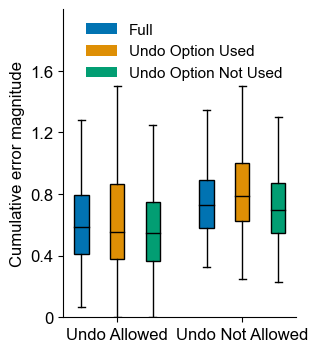

In [353]:
# figure that has 6 boxplot in one figure
%matplotlib inline

fig, ax = plt.subplots(figsize=(3, 4))

colors = sns.color_palette("colorblind")
# whisker plot
# first that full
ax.boxplot([cumulative_error_UA[:,0], cumulative_error_UNA[:,0]], positions=[1,1+3.5], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor=colors[0]), medianprops=dict(color='black'))
# then when undo option used
idx = np.where(~np.isnan(cumulative_error_UA[:,1]))[0]
# whisker plot
ax.boxplot([cumulative_error_UA[idx,1], cumulative_error_UNA[idx,1]], positions=[2,2+3.5], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor=colors[1]), medianprops=dict(color='black'), labels = ['Undo Allowed','Undo Not Allowed'])
# then when undo option not used
idx = np.where(~np.isnan(cumulative_error_UA[:,2]))[0]
# whisker plot
ax.boxplot([cumulative_error_UA[idx,2], cumulative_error_UNA[idx,2]], positions=[3,3+3.5], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor=colors[2]), medianprops=dict(color='black'))

# set xticks only 2 and 2+3.5
ax.set_xticks([2, 2+3.5], ['Undo Allowed','Undo Not Allowed'])

# show legends that shows the three different bars with three colors that shown in boxplot above
from matplotlib.patches import Patch

legend_elements = [Patch(facecolor=colors[0], label='Full'),
                   Patch(facecolor=colors[1], label='Undo Option Used'),
                   Patch(facecolor=colors[2], label='Undo Option Not Used')]

sns.despine()

# set ylim
ax.set_ylim([0, 2])
ax.set_yticks([0, 0.4, 0.8, 1.2, 1.6], ['0', '0.4', '0.8', '1.2', '1.6'])

# ylabel
ax.set_ylabel('Cumulative error magnitude', fontsize=12)

ax.legend(handles=legend_elements, loc='upper right', frameon=False, fontsize=11)

#savefigure
plt.savefig(out_dir + 'cumulative_error_fulluouuonu.png', dpi=300, bbox_inches='tight')


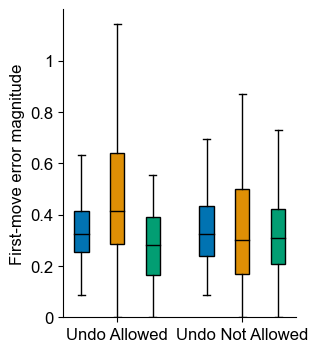

In [354]:
# figure that has 6 boxplot in one figure
%matplotlib inline

fig, ax = plt.subplots(figsize=(3, 4))

colors = sns.color_palette("colorblind")
# whisker plot
# first that full
ax.boxplot([first_move_optimality_UA[:,0], first_move_optimality_UNA[:,0]], positions=[1,1+3.5], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor=colors[0]), medianprops=dict(color='black'))
# then when undo option used
idx = np.where(~np.isnan(first_move_optimality_UA[:,1]))[0]
# whisker plot
ax.boxplot([first_move_optimality_UA[idx,1], first_move_optimality_UNA[idx,1]], positions=[2,2+3.5], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor=colors[1]), medianprops=dict(color='black'), labels = ['Undo Allowed','Undo Not Allowed'])
# then when undo option not used
idx = np.where(~np.isnan(first_move_optimality_UA[:,2]))[0]
# whisker plot
ax.boxplot([first_move_optimality_UA[idx,2], first_move_optimality_UNA[idx,2]], positions=[3,3+3.5], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor=colors[2]), medianprops=dict(color='black'))

# set xticks only 2 and 2+3.5
ax.set_xticks([2, 2+3.5], ['Undo Allowed','Undo Not Allowed'])

# show legends that shows the three different bars with three colors that shown in boxplot above
from matplotlib.patches import Patch

legend_elements = [Patch(facecolor=colors[0], label='Full'),
                   Patch(facecolor=colors[1], label='Undo Option Used'),
                   Patch(facecolor=colors[2], label='Undo Option Not Used')]

sns.despine()

# set ylim
ax.set_ylim([0, 1.2])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1], ['0', '0.2', '0.4', '0.6', '0.8', '1'])

# ylabel
ax.set_ylabel('First-move error magnitude', fontsize=12)


#savefigure
plt.savefig(out_dir + 'first_move_errormagnitude_fulluouuonu.png', dpi=300, bbox_inches='tight')

In [355]:
# statistical test for cumulative error
# wilcoxon
from scipy.stats import wilcoxon
stat, p = wilcoxon(cumulative_error_UA[:,0], cumulative_error_UNA[:,0])
print('Statistics=%.3f, p=%.10f' % (stat, p))

Statistics=618.500, p=0.0000000002


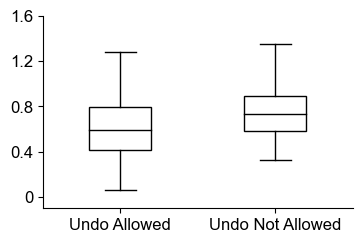

In [356]:
# whisker plot for cumulative error full
%matplotlib inline

fig, ax = plt.subplots(figsize=(4, 2.5))

# ax.set_title('Cumulative error magnitude')

colors = sns.color_palette("colorblind")
# whisker plot
ax.boxplot([cumulative_error_UA[:,0]], positions=[1], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor='w'), medianprops=dict(color='black'))
ax.boxplot([cumulative_error_UNA[:,0]], positions=[2], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor='w'), medianprops=dict(color='black'))

sns.despine()

# horizontal dashed line on 0
# ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

#set xtickslabel
ax.set_xticks([1,2])
ax.set_xticklabels(['Undo Allowed', 'Undo Not Allowed'])

#set yticks
ax.set_yticks([0, 0.4, 0.8, 1.2, 1.6], ['0', '0.4', '0.8', '1.2', '1.6'])

ax.set_ylim([-0.1, 1.6])
#save figure
plt.savefig(out_dir + 'cumulative_error_full.png', dpi=300, bbox_inches='tight')


In [357]:
from scipy.stats import wilcoxon
# get not nan index
idx = np.where(~np.isnan(cumulative_error_UA[:,1]))[0]
# statistical test that are not nan
stat, p = wilcoxon(cumulative_error_UA[idx,1], cumulative_error_UNA[idx,1])
print('Statistics=%.3f, p=%.10f' % (stat, p))

Statistics=418.500, p=0.0000000381


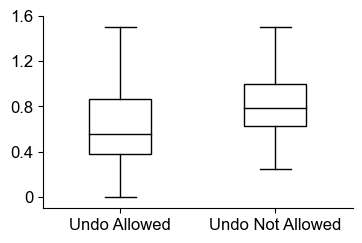

In [358]:
# whisker plot for cumulative error undo option used
%matplotlib inline

fig, ax = plt.subplots(figsize=(4, 2.5))

# ax.set_title('Cumulative error magnitude')

idx = np.where(~np.isnan(cumulative_error_UA[:,1]))[0]
# whisker plot
ax.boxplot([cumulative_error_UA[idx,1]], positions=[1], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor='w'), medianprops=dict(color='black'))
ax.boxplot([cumulative_error_UNA[idx,1]], positions=[2], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor='w'), medianprops=dict(color='black'))

sns.despine()

# horizontal dashed line on 0
# ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

#set xtickslabel
ax.set_xticks([1,2])
ax.set_xticklabels(['Undo Allowed', 'Undo Not Allowed'])

#set yticks
ax.set_yticks([0, 0.4, 0.8, 1.2, 1.6], ['0', '0.4', '0.8', '1.2', '1.6'])

# set ylim
ax.set_ylim([-0.1, 1.6])

#save figure
plt.savefig(out_dir + 'cumulative_error_undo_used.png', dpi=300, bbox_inches='tight')

In [359]:
from scipy.stats import wilcoxon
# get not nan index
idx = np.where(~np.isnan(cumulative_error_UA[:,2]))[0]
# statistical test that are not nan
stat, p = wilcoxon(cumulative_error_UA[idx,2], cumulative_error_UNA[idx,2])
print('Statistics=%.3f, p=%.10f' % (stat, p))

Statistics=642.500, p=0.0000000056


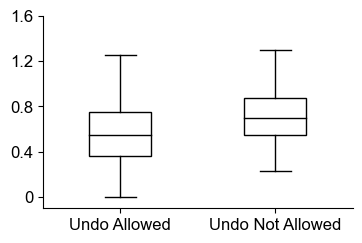

In [360]:
# whisker plot for cumulative error undo option not used
%matplotlib inline

fig, ax = plt.subplots(figsize=(4, 2.5))

# ax.set_title('Cumulative error magnitude')

idx = np.where(~np.isnan(cumulative_error_UA[:,2]))[0]
# whisker plot
ax.boxplot([cumulative_error_UA[idx,2]], positions=[1], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor='w'), medianprops=dict(color='black'))
ax.boxplot([cumulative_error_UNA[idx,2]], positions=[2], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor='w'), medianprops=dict(color='black'))

sns.despine()

# horizontal dashed line on 0
# ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

#set xtickslabel
ax.set_xticks([1,2])
ax.set_xticklabels(['Undo Allowed', 'Undo Not Allowed'])

#set yticks
ax.set_yticks([0, 0.4, 0.8, 1.2, 1.6], ['0', '0.4', '0.8', '1.2', '1.6'])

ax.set_ylim([-0.1, 1.6])
#save figure
plt.savefig(out_dir + 'cumulative_error_undo_not_used.png', dpi=300, bbox_inches='tight')

In [361]:
# statistical test for first move optimality
# wilcoxon
from scipy.stats import wilcoxon
stat, p = wilcoxon(first_move_optimality_UA[:,0], first_move_optimality_UNA[:,0])
print('Statistics=%.3f, p=%.10f' % (stat, p))

Statistics=1842.000, p=0.3203054024


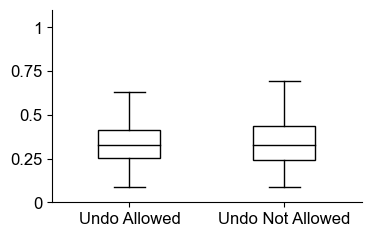

In [362]:
# whisker plot for first move optimality full
%matplotlib inline

fig, ax = plt.subplots(figsize=(4, 2.5))

# ax.set_title('Cumulative error magnitude')

idx = np.where(~np.isnan(first_move_optimality_UA[:,2]))[0]
# whisker plot
ax.boxplot([first_move_optimality_UA[:,0]], positions=[1], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor='w'), medianprops=dict(color='black'))
ax.boxplot([first_move_optimality_UNA[:,0]], positions=[2], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor='w'), medianprops=dict(color='black'))

sns.despine()

# horizontal dashed line on 0

#set xtickslabel
ax.set_xticks([1,2])
ax.set_xticklabels(['Undo Allowed', 'Undo Not Allowed'])

#set yticks from 0 to 1
ax.set_yticks([0, 0.25, 0.5, 0.75, 1], ['0', '0.25', '0.5', '0.75', '1'])

# set ylim
ax.set_ylim([0,1.1])


#save figure
plt.savefig(out_dir + 'first_move_optimality_full.png', dpi=300, bbox_inches='tight')



In [363]:
# statistical test for first move optimality undo used
from scipy.stats import wilcoxon
idx = np.where(~np.isnan(first_move_optimality_UA[:,1]))[0]
stat, p = wilcoxon(first_move_optimality_UA[idx,1], first_move_optimality_UNA[idx,1])
print('Statistics=%.3f, p=%.10f' % (stat, p))

Statistics=914.500, p=0.0001687036


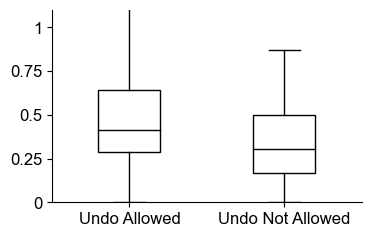

In [364]:
# whisker plot for first move optimality undo used
%matplotlib inline

fig, ax = plt.subplots(figsize=(4, 2.5))

# ax.set_title('Cumulative error magnitude')

idx = np.where(~np.isnan(first_move_optimality_UA[:,1]))[0]
# whisker plot
ax.boxplot([first_move_optimality_UA[idx,1]], positions=[1], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor='w'), medianprops=dict(color='black'))
ax.boxplot([first_move_optimality_UNA[idx,1]], positions=[2], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor='w'), medianprops=dict(color='black'))

sns.despine()

# horizontal dashed line on 0

#set xtickslabel
ax.set_xticks([1,2])
ax.set_xticklabels(['Undo Allowed', 'Undo Not Allowed'])

#set yticks from 0 to 1
ax.set_yticks([0, 0.25, 0.5, 0.75, 1], ['0', '0.25', '0.5', '0.75', '1'])

# set ylim
ax.set_ylim([0,1.1])


#save figure
plt.savefig(out_dir + 'first_move_optimality_undo_used.png', dpi=300, bbox_inches='tight')

In [365]:
# statistical test for first move optimality undo not used
from scipy.stats import wilcoxon
idx = np.where(~np.isnan(first_move_optimality_UA[:,2]))[0]
stat, p = wilcoxon(first_move_optimality_UA[idx,2], first_move_optimality_UNA[idx,2])
print('Statistics=%.3f, p=%.10f' % (stat, p))

# print mean
print(np.nanmean(first_move_optimality_UA[idx,2]), np.nanmean(first_move_optimality_UNA[idx,2]))

Statistics=1270.000, p=0.0097156915
0.2993850029737518 0.34195058849052246


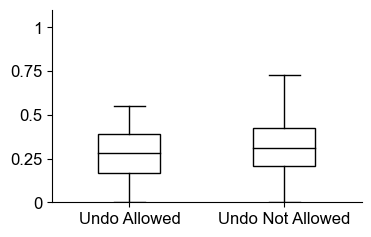

In [366]:
# whisker plot for first move optimality undo not used
%matplotlib inline

fig, ax = plt.subplots(figsize=(4, 2.5))

# ax.set_title('Cumulative error magnitude')

idx = np.where(~np.isnan(first_move_optimality_UA[:,2]))[0]
# whisker plot
ax.boxplot([first_move_optimality_UA[idx,2]], positions=[1], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor='w'), medianprops=dict(color='black'))
ax.boxplot([first_move_optimality_UNA[idx,2]], positions=[2], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor='w'), medianprops=dict(color='black'))

sns.despine()

# horizontal dashed line on 0

#set xtickslabel
ax.set_xticks([1,2])
ax.set_xticklabels(['Undo Allowed', 'Undo Not Allowed'])

#set yticks from 0 to 1
ax.set_yticks([0, 0.25, 0.5, 0.75, 1], ['0', '0.25', '0.5', '0.75', '1'])

# set ylim
ax.set_ylim([0,1.1])

#save figure
plt.savefig(out_dir + 'first_move_optimality_undo_not_used.png', dpi=300, bbox_inches='tight')

In [367]:
first_move_RT_UA /= 1000
first_move_RT_UNA /= 1000

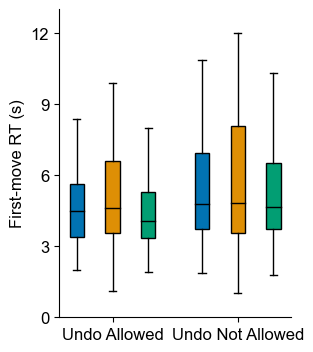

In [368]:
# figure that has 6 boxplot in one figure
%matplotlib inline

fig, ax = plt.subplots(figsize=(3, 4))

colors = sns.color_palette("colorblind")
# whisker plot
# first that full
ax.boxplot([first_move_RT_UA[:,0], first_move_RT_UNA[:,0]], positions=[1,1+3.5], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor=colors[0]), medianprops=dict(color='black'))
# then when undo option used
idx = np.where(~np.isnan(first_move_RT_UA[:,1]))[0]
# whisker plot
ax.boxplot([first_move_RT_UA[idx,1], first_move_RT_UNA[idx,1]], positions=[2,2+3.5], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor=colors[1]), medianprops=dict(color='black'), labels = ['Undo Allowed','Undo Not Allowed'])
# then when undo option not used
idx = np.where(~np.isnan(first_move_RT_UA[:,2]))[0]
# whisker plot
ax.boxplot([first_move_RT_UA[idx,2], first_move_RT_UNA[idx,2]], positions=[3,3+3.5], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor=colors[2]), medianprops=dict(color='black'))

# set xticks only 2 and 2+3.5
ax.set_xticks([2, 2+3.5], ['Undo Allowed','Undo Not Allowed'])

# show legends that shows the three different bars with three colors that shown in boxplot above
from matplotlib.patches import Patch

legend_elements = [Patch(facecolor=colors[0], label='Full'),
                   Patch(facecolor=colors[1], label='Undo Option Used'),
                   Patch(facecolor=colors[2], label='Undo Option Not Used')]

sns.despine()

# set ylim
ax.set_ylim([0, 13])
ax.set_yticks([0, 3, 6, 9, 12], ['0', '3', '6', '9', '12'])
# ax.legend(handles=legend_elements, loc='upper right', frameon=False, fontsize=11)

# ylabel
ax.set_ylabel('First-move RT (s)', fontsize=12)

#savefigure
plt.savefig(out_dir + 'first_move_RT_fulluouuonu.png', dpi=300, bbox_inches='tight')

In [71]:
# statistical test for first move RT full
from scipy.stats import wilcoxon
idx = np.where(~np.isnan(first_move_RT_UA[:,0]))[0]
stat, p = wilcoxon(first_move_RT_UA[idx,0], first_move_RT_UNA[idx,0])
print('Statistics=%.3f, p=%.10f' % (stat, p))

Statistics=1293.000, p=0.0000227520


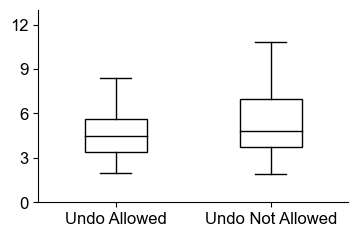

In [72]:
# whisker plot for first move RT full
%matplotlib inline

fig, ax = plt.subplots(figsize=(4, 2.5))

# ax.set_title('Cumulative error magnitude')

idx = np.where(~np.isnan(first_move_RT_UA[:,0]))[0]
# whisker plot
ax.boxplot([first_move_RT_UA[idx,0]], positions=[1], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor='w'), medianprops=dict(color='black'))
ax.boxplot([first_move_RT_UNA[idx,0]], positions=[2], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor='w'), medianprops=dict(color='black'))

sns.despine()

# horizontal dashed line on 0

#set xtickslabel
ax.set_xticks([1,2])
ax.set_xticklabels(['Undo Allowed', 'Undo Not Allowed'])

#set yticks from 0 to 12
ax.set_yticks([0, 3, 6, 9, 12], ['0', '3', '6', '9', '12'])

# set ylim
ax.set_ylim([0,13])

#save figure
plt.savefig(out_dir + 'first_move_RT_full.png', dpi=300, bbox_inches='tight')

In [73]:
# statistical test for first move RT undo used
from scipy.stats import wilcoxon
idx = np.where(~np.isnan(first_move_RT_UA[:,1]))[0]
stat, p = wilcoxon(first_move_RT_UA[idx,1], first_move_RT_UNA[idx,1])
print('Statistics=%.3f, p=%.10f' % (stat, p))

Statistics=1552.000, p=0.0461807169


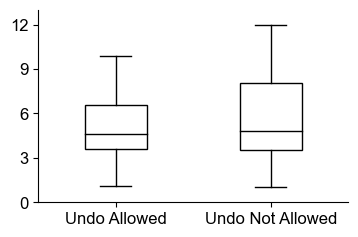

In [74]:
# whisker plot for first move RT undo used
%matplotlib inline

fig, ax = plt.subplots(figsize=(4, 2.5))

# ax.set_title('Cumulative error magnitude')

idx = np.where(~np.isnan(first_move_RT_UA[:,1]))[0]
# whisker plot
ax.boxplot([first_move_RT_UA[idx,1]], positions=[1], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor='w'), medianprops=dict(color='black'))
ax.boxplot([first_move_RT_UNA[idx,1]], positions=[2], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor='w'), medianprops=dict(color='black'))

sns.despine()

# horizontal dashed line on 0

#set xtickslabel
ax.set_xticks([1,2])
ax.set_xticklabels(['Undo Allowed', 'Undo Not Allowed'])

#set yticks from 0 to 12
ax.set_yticks([0, 3, 6, 9, 12], ['0', '3', '6', '9', '12'])

# set ylim
ax.set_ylim([0,13])

#save figure
plt.savefig(out_dir + 'first_move_RT_undo_used.png', dpi=300, bbox_inches='tight')

In [87]:
np.nanmean(first_move_RT_UA[idx,1]), first_move_RT_UA[idx,2].mean()

(5.337833524411329, 4.541143349305672)

In [75]:
# statistical test for first move RT undo not used
from scipy.stats import wilcoxon
idx = np.where(~np.isnan(first_move_RT_UA[:,2]))[0]
stat, p = wilcoxon(first_move_RT_UA[idx,2], first_move_RT_UNA[idx,2])
print('Statistics=%.3f, p=%.10f' % (stat, p))

Statistics=1039.000, p=0.0000005385


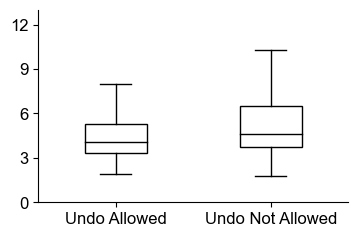

In [76]:
# whisker plot for first move RT undo not used
%matplotlib inline

fig, ax = plt.subplots(figsize=(4, 2.5))

# ax.set_title('Cumulative error magnitude')

idx = np.where(~np.isnan(first_move_RT_UA[:,2]))[0]
# whisker plot
ax.boxplot([first_move_RT_UA[idx,2]], positions=[1], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor='w'), medianprops=dict(color='black'))
ax.boxplot([first_move_RT_UNA[idx,2]], positions=[2], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor='w'), medianprops=dict(color='black'))

sns.despine()

# horizontal dashed line on 0

#set xtickslabel
ax.set_xticks([1,2])
ax.set_xticklabels(['Undo Allowed', 'Undo Not Allowed'])

#set yticks from 0 to 12
ax.set_yticks([0, 3, 6, 9, 12], ['0', '3', '6', '9', '12'])

# set ylim
ax.set_ylim([0,13])

#save figure
plt.savefig(out_dir + 'first_move_RT_undo_not_used.png', dpi=300, bbox_inches='tight')

In [77]:
RT_UA /= 1000
RT_UNA /= 1000

In [78]:
# statistical test for first move RT full
from scipy.stats import wilcoxon
idx = np.where(~np.isnan(RT_UA[:,0]))[0]
stat, p = wilcoxon(RT_UA[idx,0], RT_UNA[idx,0])
print('Statistics=%.3f, p=%.10f' % (stat, p))

Statistics=1524.000, p=0.0005779360


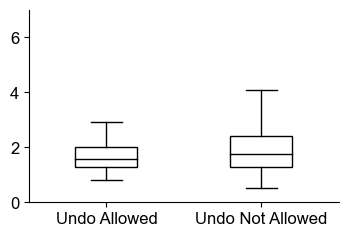

In [79]:
# whisker plot for first move RT full
%matplotlib inline

fig, ax = plt.subplots(figsize=(4, 2.5))

# ax.set_title('Cumulative error magnitude')

idx = np.where(~np.isnan(RT_UA[:,0]))[0]
# whisker plot
ax.boxplot([RT_UA[idx,0]], positions=[1], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor='w'), medianprops=dict(color='black'))
ax.boxplot([RT_UNA[idx,0]], positions=[2], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor='w'), medianprops=dict(color='black'))

sns.despine()

# horizontal dashed line on 0

#set xtickslabel
ax.set_xticks([1,2])
ax.set_xticklabels(['Undo Allowed', 'Undo Not Allowed'])

#set yticks from 0 to 6
ax.set_yticks([0,  2,  4,  6], ['0',  '2',  '4', '6'])

# set ylim
ax.set_ylim([0,7])

#save figure
plt.savefig(out_dir + 'RT_full.png', dpi=300, bbox_inches='tight')

In [80]:
# statistical test for first move RT undo used
from scipy.stats import wilcoxon
idx = np.where(~np.isnan(RT_UA[:,1]))[0]
stat, p = wilcoxon(RT_UA[idx,1], RT_UNA[idx,1])
print('Statistics=%.3f, p=%.10f' % (stat, p))

Statistics=1482.000, p=0.0228821846


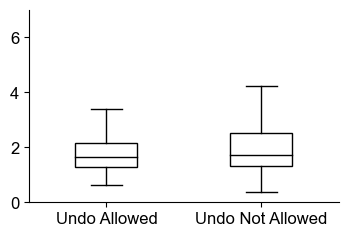

In [81]:
# whisker plot for first move RT undo used
%matplotlib inline

fig, ax = plt.subplots(figsize=(4, 2.5))

# ax.set_title('Cumulative error magnitude')

idx = np.where(~np.isnan(RT_UA[:,1]))[0]
# whisker plot
ax.boxplot([RT_UA[idx,1]], positions=[1], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor='w'), medianprops=dict(color='black'))
ax.boxplot([RT_UNA[idx,1]], positions=[2], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor='w'), medianprops=dict(color='black'))

sns.despine()

# horizontal dashed line on 0

#set xtickslabel
ax.set_xticks([1,2])
ax.set_xticklabels(['Undo Allowed', 'Undo Not Allowed'])

#set yticks from 0 to 6
ax.set_yticks([0,  2,  4,  6], ['0',  '2',  '4', '6'])

# set ylim
ax.set_ylim([0,7])


#save figure
plt.savefig(out_dir + 'RT_undo_used.png', dpi=300, bbox_inches='tight')

In [82]:
# statistical test for first move RT undo not used
from scipy.stats import wilcoxon
idx = np.where(~np.isnan(RT_UA[:,2]))[0]
stat, p = wilcoxon(RT_UA[idx,2], RT_UNA[idx,2])
print('Statistics=%.3f, p=%.10f' % (stat, p))

Statistics=1632.000, p=0.0032576912


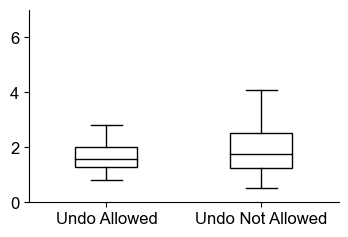

In [83]:
# whisker plot for first move RT undo not used
%matplotlib inline

fig, ax = plt.subplots(figsize=(4, 2.5))

# ax.set_title('Cumulative error magnitude')

idx = np.where(~np.isnan(RT_UA[:,2]))[0]
# whisker plot
ax.boxplot([RT_UA[idx,2]], positions=[1], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor='w'), medianprops=dict(color='black'))
ax.boxplot([RT_UNA[idx,2]], positions=[2], widths=0.4, showfliers=False, patch_artist=True, boxprops=dict(facecolor='w'), medianprops=dict(color='black'))

sns.despine()

# horizontal dashed line on 0

#set xtickslabel
ax.set_xticks([1,2])
ax.set_xticklabels(['Undo Allowed', 'Undo Not Allowed'])

#set yticks from 0 to 6
ax.set_yticks([0,  2,  4,  6], ['0',  '2',  '4', '6'])

# set ylim
ax.set_ylim([0,7])


#save figure
plt.savefig(out_dir + 'RT_undo_not_used.png', dpi=300, bbox_inches='tight')

# statistical test for three behavioral measures

In [134]:
print(dat_sbj_undo_pzi['RT'].iloc[1]/1000)

1.754


In [371]:
import os
out_dir2 =  './stat_model/final/'
print(out_dir2)
os.makedirs(out_dir2, exist_ok=True)

# make empty dataframe with the keys cumulative error, first-move optimality, first-move RT, condition, puzzleID, subjects, undoUsed
data_cond1_outcome = pd.DataFrame(columns=['cumulativeError', 'firstMoveOptimality', 'firstMoveRT', 'condition', 'puzzleID', 'subjects', 'undoUsed','puzzleMAS', 'numUndoUsed'])
data_condall_outcome = pd.DataFrame(columns=['cumulativeError', 'firstMoveOptimality', 'firstMoveRT', 'condition', 'puzzleID', 'subjects', 'undoUsed','puzzleMAS', 'numUndoUsed'])

# for each subject
for sbj in range(100):
    # for puzzle
    dat_sbj_undo  = undo_level[undo_level['subjects']==sub].sort_values(["puzzleID","index"])
    dat_sbj_basic = basic_level[basic_level['subjects']==sub].sort_values(["puzzleID","index"])

    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        dat_sbj_undo_pzi = dat_sbj_undo[dat_sbj_undo['puzzleID'] == pzi].reset_index()

        # check if the subject used undo
        cumulativeError = dat_sbj_undo_pzi['currMas'].iloc[0] - dat_sbj_undo_pzi['currMas'].iloc[-1]
        firstMoveOptimality = dat_sbj_undo_pzi['currMas'].iloc[1] - dat_sbj_undo_pzi['currMas'].iloc[0]
        firstMoveRT = dat_sbj_undo_pzi['RT'].iloc[1]/1000
        undoUsed = np.sign(dat_sbj_undo_pzi['undo'].sum())
        numUndoUsed = dat_sbj_undo_pzi['undo'].sum()

        if undoUsed == 0:
            undoUsed = -1
        else:
            undoUsed = 1

        subjects = sbj
        puzzleID = pzi
        condition = 1

        # append data_cond1_outcome
        data_cond1_outcome = data_cond1_outcome.append({'cumulativeError': cumulativeError, 'firstMoveOptimality': firstMoveOptimality, 'firstMoveRT': firstMoveRT, 'condition': condition, 'puzzleID': puzzleID, 'subjects': subjects, 'undoUsed': undoUsed,'puzzleMAS': dat_sbj_undo_pzi['currMas'].iloc[0], 'numUndoUsed':numUndoUsed}, ignore_index=True)
        data_condall_outcome = data_condall_outcome.append({'cumulativeError': cumulativeError, 'firstMoveOptimality': firstMoveOptimality, 'firstMoveRT': firstMoveRT, 'condition': condition, 'puzzleID': puzzleID, 'subjects': subjects, 'undoUsed': undoUsed,'puzzleMAS': dat_sbj_undo_pzi['currMas'].iloc[0], 'numUndoUsed':numUndoUsed}, ignore_index=True)

        dat_sbj_basic_pzi = dat_sbj_basic[dat_sbj_basic['puzzleID'] == pzi].reset_index()

        # check if the subject used undo
        cumulativeError = dat_sbj_basic_pzi['currMas'].iloc[0] - dat_sbj_basic_pzi['currMas'].iloc[-1]
        firstMoveOptimality = dat_sbj_basic_pzi['currMas'].iloc[1] - dat_sbj_basic_pzi['currMas'].iloc[0]
        firstMoveRT = dat_sbj_basic_pzi['RT'].iloc[1]/1000
        undoUsed = np.sign(dat_sbj_basic_pzi['undo'].sum())
        undoUsed = np.nan
        numUndoUsed = 0

        # append data_cond1_outcome
        data_condall_outcome = data_condall_outcome.append({'cumulativeError': cumulativeError, 'firstMoveOptimality': firstMoveOptimality, 'firstMoveRT': firstMoveRT, 'condition': 0, 'puzzleID': puzzleID, 'subjects': subjects, 'undoUsed': undoUsed,'puzzleMAS': dat_sbj_basic_pzi['currMas'].iloc[0], 'numUndoUsed':numUndoUsed}, ignore_index=True)


./stat_model/final/


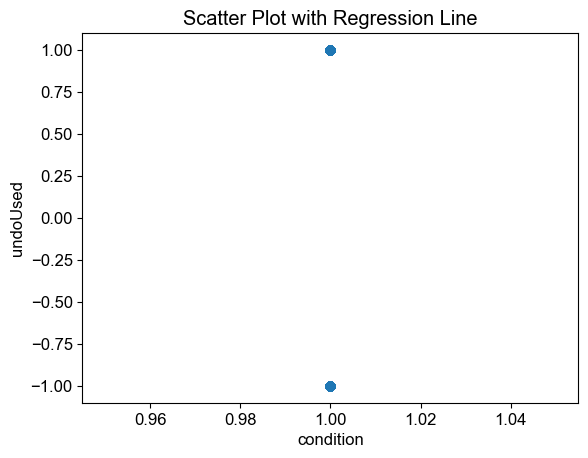

ValueError: array must not contain infs or NaNs

In [372]:
%matplotlib inline
# Scatter plot with regression line
sns.regplot(x='condition', y='undoUsed', data=data_condall_outcome)
plt.title('Scatter Plot with Regression Line')
plt.show()

# Calculate and print Pearson's correlation coefficient
correlation, p_value = stats.pearsonr(data_condall_outcome['condition'], data_condall_outcome['undoUsed'])
print("Correlation coefficient:", correlation)
print("P-value:", p_value)


In [103]:
import rpy2
import rpy2.situation as r_situation
print(r_situation.get_r_home())

!python -m rpy2.situation


/Users/dongjaekim/opt/anaconda3/envs/base310/lib/R
rpy2 version:
3.5.11
Python version:
3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:39:40) [Clang 15.0.7 ]
Looking for R's HOME:
    Environment variable R_HOME: None
    Calling `R RHOME`: /Users/dongjaekim/opt/anaconda3/envs/base310/lib/R
    Environment variable R_LIBS_USER: None
R's additions to LD_LIBRARY_PATH:

R version:
    In the PATH: R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:
  include:
  ['/Users/dongjaekim/opt/anaconda3/envs/base310/lib/R/include']
  libraries:
  ['R', 'pcre2-8', 'lzma', 'bz2', 'z', 'dl', 'm', 'iconv', 'icuuc', 'icui18n']
  library_dirs:
  ['/Users/dongjaekim/opt/anaconda3/envs/base310/lib', '/Users/dongjaekim/opt/anaconda3/envs/base310/lib/R/lib', '/Users/dongjaekim/opt/anaconda3/envs/base310/lib']
  extra_compile_args:
  ['-std=c99']
  extra_link_args:
  ['-fopenmp', '-Wl,

In [104]:
# import rpy2's package module
import rpy2.robjects.packages as rpackages

# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

<rpy2.rinterface_lib.sexp.NULLType object at 0x1569481c0> [RTYPES.NILSXP]

In [105]:
# R package names
packnames = ('lme4', 'MASS')

# R vector of strings
from rpy2.robjects.vectors import StrVector

# Selectively install what needs to be install.
# We are fancy, just because we can.
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))

In [106]:
%load_ext rpy2.ipython

from rpy2.robjects.packages import importr
# import R's "base" package
lme4 = importr('lme4')
mass = importr('MASS')

In [107]:
# Set the style to remove top and right borders
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
# set the font size
plt.rcParams.update({'font.size': 11})
# remove legend edge
plt.rcParams['legend.frameon'] = False


        data_cond1_outcome = data_cond1_outcome.append({'cumulativeError': cumulativeError, 'firstMoveOptimality': firstMoveOptimality, 'firstMoveRT': firstMoveRT, 'condition': condition, 'puzzleID': puzzleID, 'subjects': subjects, 'undoUsed': undoUsed}, ignore_index=True)

In [373]:
%%R -i data_condall_outcome,out_dir2
data_condall_outcome$subjects <- as.factor(data_condall_outcome[,"subjects"])
data_condall_outcome$puzzleID <- as.factor(data_condall_outcome[,"puzzleID"])
data_condall_outcome$puzzleMAS <- as.factor(data_condall_outcome[,"puzzleMAS"])
# data_cond1_outcome$undoUsed <- as.factor(data_cond1_outcome[,"undoUsed"])
data_condall_outcome$condition <- as.factor(data_condall_outcome[,"condition"])


model_error1 = lme4::glmer(cumulativeError ~  1 + undoUsed + condition + (1|subjects) + (1|puzzleMAS),
                                  data = data_condall_outcome, family = "poisson")


summary(model_error1)

R[write to console]: Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]) : 
  contrasts can be applied only to factors with 2 or more levels




Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]) : 
  contrasts can be applied only to factors with 2 or more levels


RInterpreterError: Failed to parse and evaluate line 'data_condall_outcome$subjects <- as.factor(data_condall_outcome[,"subjects"])\ndata_condall_outcome$puzzleID <- as.factor(data_condall_outcome[,"puzzleID"])\ndata_condall_outcome$puzzleMAS <- as.factor(data_condall_outcome[,"puzzleMAS"])\n# data_cond1_outcome$undoUsed <- as.factor(data_cond1_outcome[,"undoUsed"])\ndata_condall_outcome$condition <- as.factor(data_condall_outcome[,"condition"])\n\n\nmodel_error1 = lme4::glmer(cumulativeError ~  1 + undoUsed + condition + (1|subjects) + (1|puzzleMAS),\n                                  data = data_condall_outcome, family = "poisson")\n\n\nsummary(model_error1)\n'.
R error message: 'Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]) : \n  contrasts can be applied only to factors with 2 or more levels'

In [229]:
%%R -i data_condall_outcome,out_dir2
data_condall_outcome$subjects <- as.factor(data_condall_outcome[,"subjects"])
data_condall_outcome$puzzleID <- as.factor(data_condall_outcome[,"puzzleID"])
data_condall_outcome$puzzleMAS <- as.factor(data_condall_outcome[,"puzzleMAS"])
# data_cond1_outcome$undoUsed <- as.factor(data_cond1_outcome[,"undoUsed"])
data_condall_outcome$condition <- as.factor(data_condall_outcome[,"condition"])


model_error1 = lme4::glmer(cumulativeError ~  1 + undoUsed + condition + (1|subjects) + (1|puzzleMAS),
                                  data = data_condall_outcome, family = "poisson")


summary(model_error1)

R[write to console]: boundary (singular) fit: see help('isSingular')



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: cumulativeError ~ 1 + undoUsed + condition + (1 | subjects) +  
    (1 | puzzleMAS)
   Data: data_condall_outcome

     AIC      BIC   logLik deviance df.resid 
 16948.2  16983.8  -8469.1  16938.2     9195 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.9798 -0.6979 -0.2110  0.5440  2.2641 

Random effects:
 Groups    Name        Variance Std.Dev.
 subjects  (Intercept) 0.000    0.000   
 puzzleMAS (Intercept) 6.328    2.516   
Number of obs: 9200, groups:  subjects, 100; puzzleMAS, 6

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.25417    0.97837  -1.282      0.2    
undoUsed     0.36601    0.02165  16.909  < 2e-16 ***
condition1  -0.13362    0.02757  -4.846 1.26e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
           (Intr) undUsd
undoUsed   -0

In [201]:
%%R -i data_condall_outcome,out_dir2
data_condall_outcome$subjects <- as.factor(data_condall_outcome[,"subjects"])
data_condall_outcome$puzzleID <- as.factor(data_condall_outcome[,"puzzleID"])
data_condall_outcome$puzzleMAS <- as.factor(data_condall_outcome[,"puzzleMAS"])
# data_cond1_outcome$undoUsed <- as.factor(data_cond1_outcome[,"undoUsed"])
data_condall_outcome$condition <- as.factor(data_condall_outcome[,"condition"])


model_error1 = lme4::glmer(cumulativeError ~  1 + undoUsed + condition + (1|subjects) + (1+undoUsed|puzzleID),
                                  data = data_condall_outcome, family = "poisson")


summary(model_error1)

R[write to console]: boundary (singular) fit: see help('isSingular')



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: cumulativeError ~ 1 + undoUsed + condition + (1 | subjects) +  
    (1 + undoUsed + condition | puzzleID)
   Data: data_condall_outcome

     AIC      BIC   logLik deviance df.resid 
  4620.0   4684.3  -2300.0   4600.0     4591 

Scaled residuals: 
      Min        1Q    Median        3Q       Max 
-0.054523 -0.004408 -0.004408  0.001120  0.002077 

Random effects:
 Groups   Name        Variance  Std.Dev.  Corr       
 subjects (Intercept) 0.000e+00 0.000e+00            
 puzzleID (Intercept) 2.156e-10 1.468e-05            
          undoUsed    2.295e+01 4.790e+00 -0.70      
          condition1  3.045e+01 5.518e+00  0.81 -0.79
Number of obs: 4601, groups:  subjects, 100; puzzleID, 46

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.762e-06  1.138e+00   0.000        1    
undoUsed     4.135e+00  9.121e-01   4.534 5.80e-0

In [223]:
%%R -i data_condall_outcome,out_dir2
data_condall_outcome$subjects <- as.factor(data_condall_outcome[,"subjects"])
data_condall_outcome$puzzleID <- as.factor(data_condall_outcome[,"puzzleID"])
data_condall_outcome$puzzleMAS <- as.factor(data_condall_outcome[,"puzzleMAS"])
# data_cond1_outcome$undoUsed <- as.factor(data_cond1_outcome[,"undoUsed"])
data_condall_outcome$condition <- as.factor(data_condall_outcome[,"condition"])


model_error1 = lme4::glmer(cumulativeError ~  1 + numUndoUsed + condition + (1|subjects) + (1+numUndoUsed|puzzleID),
                                  data = data_condall_outcome, family = "poisson")


summary(model_error1)

R[write to console]: boundary (singular) fit: see help('isSingular')



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: cumulativeError ~ 1 + numUndoUsed + condition + (1 + numUndoUsed |  
    subjects) + (1 + numUndoUsed | puzzleID)
   Data: data_condall_outcome

     AIC      BIC   logLik deviance df.resid 
 12043.1  12107.2  -6012.5  12025.1     9191 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.08300 -0.05163 -0.03062  0.00334  1.29355 

Random effects:
 Groups   Name        Variance  Std.Dev.  Corr 
 subjects (Intercept) 0.000e+00 0.000e+00      
          numUndoUsed 4.637e-15 6.809e-08  NaN 
 puzzleID (Intercept) 1.559e+01 3.949e+00      
          numUndoUsed 1.957e-01 4.424e-01 -0.58
Number of obs: 9200, groups:  subjects, 100; puzzleID, 46

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.07979    0.68211  -4.515 6.33e-06 ***
numUndoUsed  0.22309    0.13657   1.633    0.102    
condition1  -0.35178    0.03472 

In [208]:
%%R -i data_cond1_outcome,out_dir2
data_cond1_outcome$subjects <- as.factor(data_cond1_outcome[,"subjects"])
data_cond1_outcome$puzzleID <- as.factor(data_cond1_outcome[,"puzzleID"])
data_cond1_outcome$undoUsed <- as.factor(data_cond1_outcome[,"undoUsed"])
data_cond1_outcome$condition <- as.factor(data_cond1_outcome[,"condition"])


model_error = lme4::glmer(cumulativeError ~  1 + undoUsed + (1 |subjects) + (1 +undoUsed |puzzleID),
                                  data = data_cond1_outcome, family = "poisson")
  # 4612.1   4637.9  -2302.1   4604.1     4596
summary(model_error)
# anova(model_error1, model_error2)

R[write to console]: boundary (singular) fit: see help('isSingular')



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: cumulativeError ~ 1 + undoUsed + (1 | subjects) + (1 + undoUsed |  
    puzzleID)
   Data: data_cond1_outcome

     AIC      BIC   logLik deviance df.resid 
  4610.0   4648.6  -2299.0   4598.0     4594 

Scaled residuals: 
      Min        1Q    Median        3Q       Max 
-0.054524 -0.004408 -0.004408  0.001120  0.002077 

Random effects:
 Groups   Name        Variance  Std.Dev.  Corr 
 subjects (Intercept) 1.895e-15 4.353e-08      
 puzzleID (Intercept) 9.527e+01 9.760e+00      
          undoUsed1   6.495e+01 8.059e+00 -0.95
Number of obs: 4600, groups:  subjects, 100; puzzleID, 46

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -10.663      1.486  -7.174 7.30e-13 ***
undoUsed1      8.271      1.811   4.567 4.94e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
      

In [227]:
%%R -i data_cond1_outcome,out_dir2
data_cond1_outcome$subjects <- as.factor(data_cond1_outcome[,"subjects"])
data_cond1_outcome$puzzleID <- as.factor(data_cond1_outcome[,"puzzleID"])
data_cond1_outcome$undoUsed <- as.factor(data_cond1_outcome[,"undoUsed"])
data_cond1_outcome$condition <- as.factor(data_cond1_outcome[,"condition"])


model_error = lme4::glmer(cumulativeError ~  1 + numUndoUsed + (1 |subjects) + (1 + numUndoUsed|puzzleID),
                                  data = data_cond1_outcome, family = "poisson")
  # 4612.4   4638.1  -2302.2   4604.4     4596
summary(model_error)
# anova(model_error1, model_error2)

R[write to console]: boundary (singular) fit: see help('isSingular')



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: 
cumulativeError ~ 1 + numUndoUsed + (1 | subjects) + (1 + numUndoUsed |  
    puzzleID)
   Data: data_cond1_outcome

     AIC      BIC   logLik deviance df.resid 
  4605.1   4643.7  -2296.6   4593.1     4594 

Scaled residuals: 
      Min        1Q    Median        3Q       Max 
-0.043312 -0.006029 -0.006029  0.001188  0.005446 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 subjects (Intercept)  0.0000  0.0000        
 puzzleID (Intercept) 83.5283  9.1394        
          numUndoUsed  0.1578  0.3973   -1.00
Number of obs: 4600, groups:  subjects, 100; puzzleID, 46

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -9.91869    1.41339  -7.018 2.26e-12 ***
numUndoUsed  0.43148    0.06158   7.007 2.44e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
       

Significnat intercept: mindset effect

why positive effect of undo used? : maybe from they used undo when inherently they make more errors.
then how to solve it?

puzzleMAS?
but in that case we should deal with the correlated puzzleMAS nad puzzleID. which is called colinearity issue
"model struggles to separate the effects of puzzle MAS from the random effects of puzzle ID"



In [370]:
%%R -i data_condall_outcome


data_cond1_outcome$subjects <- as.factor(data_cond1_outcome[,"subjects"])
# data_cond1_outcome$puzzleID <- as.factor(data_cond1_outcome[,"puzzleID"])
data_cond1_outcome$undoUsed <- as.factor(data_cond1_outcome[,"undoUsed"])
data_cond1_outcome$condition <- as.factor(data_cond1_outcome[,"condition"])


model_ancova <- lm(cumulativeError ~ undoUsed + condition + puzzleMAS, data = data_condall_outcome)

summary(model_ancova)


Call:
lm(formula = cumulativeError ~ undoUsed + condition + puzzleMAS, 
    data = data_condall_outcome)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.9506 -0.5817 -0.2127  0.4183  1.8649 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.078623   0.069583 -15.501  < 2e-16 ***
undoUsed     0.223631   0.011320  19.755  < 2e-16 ***
condition   -0.064666   0.014754  -4.383 1.18e-05 ***
puzzleMAS    0.184478   0.007249  25.448  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6749 on 9196 degrees of freedom
Multiple R-squared:  0.09169,	Adjusted R-squared:  0.09139 
F-statistic: 309.4 on 3 and 9196 DF,  p-value: < 2.2e-16



# Results in different city (undo target)

## different city (undo target)

In [ ]:
undo_same_diff = []

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    undo_same_diff_puzzle = []
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        same_puzzle = 0
        diff_puzzle = 0

        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()

        lastUndo_idx = dat_sbj_pzi[dat_sbj_pzi["lastUndo"]==1].index

        idxx = np.array(dat_sbj_pzi["choice"][lastUndo_idx-1]) != np.array(dat_sbj_pzi["choice"][lastUndo_idx+1])
        diff_puzzle += np.sum(idxx)
        idxx = np.array(dat_sbj_pzi["choice"][lastUndo_idx-1]) == np.array(dat_sbj_pzi["choice"][lastUndo_idx+1])
        same_puzzle += np.sum(idxx)

        undo_same_diff_puzzle.append([same_puzzle, diff_puzzle])
    undo_same_diff_puzzle =  np.array(undo_same_diff_puzzle)
    undo_same_diff_puzzle =  np.sum(undo_same_diff_puzzle,axis=0)

    if np.sum(undo_same_diff_puzzle)==0:
        print(sub) # who does not undo

    undo_same_diff.append(undo_same_diff_puzzle)

undo_same_diff = np.array(undo_same_diff)

In [ ]:
# exclude some never undoing subjects
undo_same_diff = undo_same_diff[np.where(np.sum(np.array(undo_same_diff),axis=1)!=0),:]
undo_same_diff = undo_same_diff.squeeze()
undo_same_diff_p = undo_same_diff/ np.sum(undo_same_diff,axis = 1)[:,None]

In [ ]:
np.mean(undo_same_diff_p,axis=0)

In [ ]:
%matplotlib inline

plt.figure(figsize=(2,4))
plt.bar(range(2), np.mean(undo_same_diff_p,axis=0),
        color=[.7,.7,.7], edgecolor = 'k',
        yerr=np.std(undo_same_diff_p,axis = 0)/np.sqrt(undo_same_diff_p.shape[0]))
plt.xticks([0,1], ['Same','Different'])
plt.ylabel('Proportion')
# remove right and top frame
sns.despine()

plt.xlabel('move after undo end')

# save figure
plt.savefig(out_dir + '/undo_same_diff.png', dpi=300, bbox_inches='tight')

In [ ]:
#wilcoxon signed-rank test
stat, p = wilcoxon(undo_same_diff_p[:,0], undo_same_diff_p[:,1])
print(stat)
print(p)

## ( same x different ) x ( better, equally good, worse )

In [ ]:
sub = 0
dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
pzi = 1

In [ ]:
undo_same_diff = []
undo_same_diff_weqb = []

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    same_puzzle = 0
    same_worse_eq_better = np.array([0,0,0])
    diff_puzzle = 0
    diff_worse_eq_better = np.array([0,0,0])
    for pzi in np.unique(sc_data_choice_level['puzzleID']):

        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()

        lastUndo_idx = dat_sbj_pzi[dat_sbj_pzi["lastUndo"]==1].index

        idxx_diff = np.array(dat_sbj_pzi["choice"][lastUndo_idx-1]) != np.array(dat_sbj_pzi["choice"][lastUndo_idx+1])
        diff_puzzle += np.sum(idxx_diff)

        idxx_same = np.array(dat_sbj_pzi["choice"][lastUndo_idx-1]) == np.array(dat_sbj_pzi["choice"][lastUndo_idx+1])
        same_puzzle += np.sum(idxx_same)

        mas_gain = np.array(dat_sbj_pzi["currMas"][lastUndo_idx+1]) - np.array(dat_sbj_pzi["currMas"][lastUndo_idx-1])

        idxx_w  = mas_gain < 0
        idxx_eq = mas_gain == 0
        idxx_b  = mas_gain > 0

        # find intersection between np.where(idxx_diff) and np.where(idxx_w), np.where(idxx_eq), np.where(idxx_b)
        idxx_diff_w = np.intersect1d(np.where(idxx_diff)[0], np.where(idxx_w)[0])
        idxx_diff_eq = np.intersect1d(np.where(idxx_diff)[0], np.where(idxx_eq)[0])
        idxx_diff_b = np.intersect1d(np.where(idxx_diff)[0], np.where(idxx_b)[0])

        diff_worse_eq_better += np.array([len(idxx_diff_w), len(idxx_diff_eq), len(idxx_diff_b)])

        # find intersection between np.where(idxx_same) and np.where(idxx_w), np.where(idxx_eq), np.where(idxx_b)
        idxx_same_w = np.intersect1d(np.where(idxx_same)[0], np.where(idxx_w)[0])
        idxx_same_eq = np.intersect1d(np.where(idxx_same)[0], np.where(idxx_eq)[0])
        idxx_same_b = np.intersect1d(np.where(idxx_same)[0], np.where(idxx_b)[0])

        same_worse_eq_better += np.array([len(idxx_same_w), len(idxx_same_eq), len(idxx_same_b)])

    undo_same_diff_puzzle =  np.array([same_puzzle, diff_puzzle])
    undo_same_diff_weqb_puzzle = np.array([*same_worse_eq_better, *diff_worse_eq_better])

    if np.sum(undo_same_diff_puzzle)==0:
        print(sub) # who does not undo

    undo_same_diff.append(undo_same_diff_puzzle)
    undo_same_diff_weqb.append(undo_same_diff_weqb_puzzle)

undo_same_diff = np.array(undo_same_diff)
undo_same_diff_weqb = np.array(undo_same_diff_weqb)

In [ ]:
# exclude some never undoing subjects
undo_same_diff_weqb = undo_same_diff_weqb[np.where(np.sum(np.array(undo_same_diff_weqb),axis=1)!=0),:]
undo_same_diff_weqb = undo_same_diff_weqb.squeeze()
undo_same_diff_weqb_p = undo_same_diff_weqb/ np.sum(undo_same_diff_weqb,axis = 1)[:,None]

In [ ]:
%matplotlib inline

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
# bar plot for undo_same_diff_weqb

fig, ax = plt.subplots(1,1,figsize=(4,4))
colors = ['w','0.7','0.3']
for each in range(3):
    ax.bar(np.arange(2)*3+each, np.mean(undo_same_diff_weqb_p[:, np.arange(2)*3+each],axis=0), yerr = np.std(undo_same_diff_weqb_p[:, np.arange(2)*3+each],axis=0)/np.sqrt(undo_same_diff_weqb[:, np.arange(2)*3+each].shape[0]), color = colors[each],edgecolor = 'k')


# ax.bar(np.arange(6), np.mean(undo_same_diff_weqb_p,axis=0), yerr = np.std(undo_same_diff_weqb_p,axis=0)/np.sqrt(undo_same_diff_weqb.shape[0]), color = ['w','0.5','k'],edgecolor = 'k')
sns.despine()

# ax.set_xticks(np.arange(6))
# ax.set_xticklabels(['','Same','','','Different',''])

ax.set_xticks([1,4])
ax.set_xticklabels(['Same','Different'])

# set y lim
ax.set_ylim([0,0.45])

# set y ticks
ax.set_yticks(np.arange(0,0.5,0.1))
# set ytickslabel in string
ax.set_yticklabels(['0','0.1','0.2','0.3','0.4'])

# legend that says worse, equally good, better, without bounding box
ax.legend(['worse','equally good','better'],loc='upper left', frameon=False)

ax.set_xlabel('move after undoing')
ax.set_ylabel('Proportion')

# save figure
plt.savefig(out_dir + '/figure_worse_better_with_same_diff.png', dpi=300, bbox_inches='tight')


# Overlapped sequence

### overlapped sequence from all of the prev seqs.

In [ ]:
import difflib

def get_overlap(s1, s2):
    #
    s = difflib.SequenceMatcher(None, s1, s2)
    pos_a, pos_b, size = s.find_longest_match(0, len(s1), 0, len(s2))
    return s1[pos_a:pos_a+size]

def get_overlaplist(l1,l2,minlen=1):
    # return overlaping numbers in sequence
    matched_seq = []
    for i1 in range(len(l1)):
#         print('l1:{}'.format(i1))
        matches = [i2 for i2 in range(len(l2)) if l2[i2] == l1[i1]]
#         print(matches)
        for m in matches:
            matched_seq_ = []
            i_a = 0
            while ((i1+i_a)<len(l1)) and ((m+i_a)< len(l2)):
                if l1[i1+i_a]==l2[m+i_a]:
                    matched_seq_.append(l1[i1+i_a])
                    i_a += 1
                else:
                    break
            matched_seq.append(matched_seq_)

    idx = np.argsort([len(seq) for seq in matched_seq])[::-1]
#     print(idx)

    seqs_ = []
    for i in idx:
        if len(seqs_) == 0:
            seqs_.append(matched_seq[i])
        else:
            if not np.any([np.all(np.isin(matched_seq[i],seq)) for seq in seqs_]):
                seqs_.append(matched_seq[i])
    matched_seq = seqs_.copy()
    idx = np.argsort([len(seq) for seq in matched_seq])
    seqs_ = []
    for i in idx:
        if len(seqs_) == 0:
            seqs_.append(matched_seq[i])
        else:
            if not np.any([np.all(np.isin(matched_seq[i],seq)) for seq in seqs_]):
                seqs_.append(matched_seq[i])

    seqs = []
    for seq in seqs_:
#         print(len(seq))
        if not len(seq)<minlen:
            seqs.append(seq)

    return seqs

def trimmer(matched_seq,minlen=1):
    idx = np.argsort([len(seq) for seq in matched_seq])[::-1]
#     print(idx)

    seqs_ = []
    for i in idx:
        if len(seqs_) == 0:
            seqs_.append(matched_seq[i])
        else:
            if not np.any([np.all(np.isin(matched_seq[i],seq)) for seq in seqs_]):
                seqs_.append(matched_seq[i])
    matched_seq = seqs_.copy()
    idx = np.argsort([len(seq) for seq in matched_seq])
    seqs_ = []
    for i in idx:
        if len(seqs_) == 0:
            seqs_.append(matched_seq[i])
        else:
            if not np.any([np.all(np.isin(matched_seq[i],seq)) for seq in seqs_]):
                seqs_.append(matched_seq[i])

    seqs = []
    for seq in seqs_:
#         print(len(seq))
        if not len(seq)<minlen:
            seqs.append(seq)

    return seqs

In [ ]:
minlen_of_seq = 0

overlap_seq_inorder = []
overlap_seq_inorder_inlen=[]
overlap_seq_inorder_num = []
overlap_seq_inorder_num_inlen=[]

overlap_seq_inorder_norm = []
overlap_seq_inorder_num_norm = []
overlap_seq_inorder_norm_p = []
overlap_seq_inorder_num_norm_p = []


length_undone = []
length_undone_p = []

currmas = []
currmas_inlen=[]

currmas_num = []
currmas_num_inlen=[]

length_seq = []
length_seq_persub_p = []
length_num_persub_p = []

length_seq_persub = []
length_num_persub = []

mas_undone_tot= []
length_undone_tot=[]

overlap_seq_inorder_norm_tot = []
overlap_seq_inorder_num_norm_tot = []
length_undone_norm_tot = []

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    overlap_seq_inorder_for_puzzle = []
    overlap_seq_inorder_inlen_for_puzzle=[]

    overlap_seq_inorder_num_for_puzzle = []
    overlap_seq_inorder_num_inlen_for_puzzle=[]

    length_undone_norm_for_puzzle = []
    overlap_seq_inorder_norm_for_puzzle = []
    overlap_seq_inorder_num_norm_for_puzzle = []

    length_undone_for_puzzle = []
    length_undone_for_puzzle_p = []

    currmas_for_puzzle = []
    currmas_inlen_for_puzzle=[]

    length_seq_persub_for_puzzle = []
    length_num_persub_for_puzzle = []
    currmas_num_for_puzzle = []
    currmas_num_inlen_for_puzzle=[]

    mas_undone_for_puzzle = []

    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()

        firstUndo_idx = dat_sbj_pzi[dat_sbj_pzi["firstUndo"]==1].index
        path_bf_undo = dat_sbj_pzi["currMas"][firstUndo_idx-1] # the mas of the state before undo

        lastUndo_idx = dat_sbj_pzi[dat_sbj_pzi["lastUndo"]==1].index
        path_af_undo = dat_sbj_pzi["currMas"][lastUndo_idx+1] # the mas of the state after undo

        submit_idx =  pd.Int64Index([len(dat_sbj_pzi)-1])


        if len(firstUndo_idx)>0:
            if len(firstUndo_idx)==1: #
                seq_bf = dat_sbj_pzi["path"][firstUndo_idx-1]
                seq_af = dat_sbj_pzi["path"][submit_idx]
                seq_im = dat_sbj_pzi["path"][lastUndo_idx]
                currmas_bf = dat_sbj_pzi["currMas"][lastUndo_idx-1]
                currmas_af = dat_sbj_pzi["currMas"][lastUndo_idx+1]

            else:
                seq_bf = dat_sbj_pzi["path"][firstUndo_idx-1]
                t_idx = (firstUndo_idx[1:]-1).to_list()
                t_idx.append(submit_idx.item())
                seq_af = dat_sbj_pzi["path"][t_idx]
                seq_im = dat_sbj_pzi["path"][lastUndo_idx]
                currmas_bf = dat_sbj_pzi["currMas"][lastUndo_idx-1]
                currmas_af = dat_sbj_pzi["currMas"][lastUndo_idx+1]

            seq_im = seq_im.reset_index()
            pathStr_im = [seq_im.loc[i].path.strip('[').strip(']') for i in range(len(seq_im))]
            pathList_im = [[int(i) for i in pathStr_im[j].split(', ')]  for j in range(len(pathStr_im))]
            pathStr_im = [" ".join([str(a) for a in pathList_im[j]]) for j in range(len(seq_im))]

            seq_bf = seq_bf.reset_index()
            pathStr_bf = [seq_bf.loc[i].path.strip('[').strip(']') for i in range(len(seq_bf))]
            pathList_bf = [[int(i) for i in pathStr_bf[j].split(', ')]  for j in range(len(pathStr_bf))]
            pathStr_bf = [" ".join([str(a) for a in pathList_bf[j]]) for j in range(len(seq_bf))]

            seq_af = seq_af.reset_index()
            pathStr_af = [seq_af.loc[i].path.strip('[').strip(']') for i in range(len(seq_af))]
            pathList_af = [[int(i) for i in pathStr_af[j].split(', ')]  for j in range(len(pathStr_af))]
            pathStr_af = [" ".join([str(a) for a in pathList_af[j]]) for j in range(len(seq_af))]

            strarray = [np.setdiff1d([str(i ) for i in pathList_bf[i]],[str(i) for i in pathList_im[i]]).tolist() for i in range(len(pathList_bf))]
            pathList_bfim = [[int(a) for a in strarray[j]] for j in range(len(strarray))]
            # pathList_bfim = [np.setdiff1d(np.array(pathList_bf[i]),np.array(pathList_im[i])).tolist() for i in range(len(pathList_bf))]
            pathStr_bfim = [" ".join([str(a) for a in pathList_bfim[j]]) for j in range(len(pathList_im))]

            strarray = [np.setdiff1d([str(i ) for i in pathList_af[i]],[str(i) for i in pathList_im[i]]).tolist() for i in range(len(pathList_af))]
            pathList_afim = [[int(a) for a in strarray[j]] for j in range(len(strarray))]
            # pathList_afim = [np.setdiff1d(np.array(pathList_af[i]),np.array(pathList_im[i])).tolist() for i in range(len(pathList_af))]
            pathStr_afim = [" ".join([str(a) for a in pathList_afim[j]]) for j in range(len(pathList_im))]

            currmas_dif = np.array(currmas_af) - np.array(currmas_bf)


            overlap_seq_2 = []
            seq_inorder_2 = []
            currmas_dif_2 = []
            overlap_num_city = []
            overlap_seq_foreach = []
            for i in range(len(seq_af)):
                temp = []
                for j in range(i+1):
            #         temp.append(get_overlaplist(pathList_afim[i], pathList_bfim[j]))
                    temptemp = get_overlaplist(pathList_afim[i], pathList_bfim[j])
                    if not len(temptemp)==0:
                        temp.extend(temptemp)

                temp = trimmer(temp)
                if len(temp)==0:
                    temp.append([])

                overlap_num_city_ = 0
                for seq in temp:
                    overlap_num_city_ += len(seq)
                overlap_num_city.append(overlap_num_city_)
                seq_inorder_2.append(temp)

            #     len_seq_inorder_2 = [len(s) for s in temp if len(s)!=0]
                len_seq_inorder_2 =[]
                tempcurd = []
                for s in temp:
#                     print('*')
                    if len(s)==0:
                        len_seq_inorder_2.append(0)
                    else:
                        len_seq_inorder_2.append(len(s))
                    tempcurd.append(currmas_dif[i])



                overlap_seq_2.extend(len_seq_inorder_2)
                currmas_dif_2.extend(tempcurd)
                overlap_seq_foreach.append(len_seq_inorder_2)
#                 print(overlap_seq_2)
#                 print(currmas_dif_2)

            # find the index pathList_afim's len is shorter than minlen_of_seq
            idx = [i for i in range(len(pathList_afim)) if len(pathList_afim[i])>minlen_of_seq]

            temp_inorder = np.array([max(seq) for seq in overlap_seq_foreach])/np.array([len(seq) for seq in pathList_afim]).tolist()

            overlap_seq_inorder_norm_for_puzzle.extend(temp_inorder[idx])

            temp_rglssorder = np.array(overlap_num_city)/np.array([len(seq) for seq in pathList_afim]).tolist()

            # find the index pathList_afim's len is shorter than minlen_of_seq

            overlap_seq_inorder_num_norm_for_puzzle.extend(temp_rglssorder[idx])

            length_undone_norm_for_puzzle.extend(np.array([len(seq) for seq in pathList_afim])[idx].tolist())

            # print(np.array(overlap_num_city)/np.array([len(seq) for seq in pathList_afim]))
            # print(np.array([max(seq) for seq in overlap_seq_foreach])/np.array([len(seq) for seq in pathList_afim]))


            overlap_seq_inorder_for_puzzle.append([np.sum(np.array(overlap_seq_2)==0), np.sum(np.array(overlap_seq_2)!=0)])
            overlap_seq_inorder_inlen_for_puzzle.append([np.sum(np.array(overlap_seq_2)==0), np.sum(np.array(overlap_seq_2)==1),
                                                         np.sum(np.array(overlap_seq_2)==2), np.sum(np.array(overlap_seq_2)==3),
                                                         np.sum(np.array(overlap_seq_2)==4), np.sum(np.array(overlap_seq_2)==5), np.sum(np.array(overlap_seq_2)>5),])


            currmas_for_puzzle.append([np.sum(np.array(currmas_dif_2)[np.array(overlap_seq_2)==0]) , np.sum(np.array(currmas_dif_2)[np.array(overlap_seq_2)!=0]) ] )
            currmas_inlen_for_puzzle.append([np.sum(np.array(currmas_dif_2)[np.array(overlap_seq_2)==0]), np.sum(np.array(currmas_dif_2)[np.array(overlap_seq_2)==1]),
                                                         np.sum(np.array(overlap_seq_2)==2), np.sum(np.array(overlap_seq_2)==3),
                                                         np.sum(np.array(overlap_seq_2)==4), np.sum(np.array(overlap_seq_2)==5), np.sum(np.array(overlap_seq_2)>5),])


            overlap_seq_inorder_num_for_puzzle.append([np.sum(np.array(overlap_num_city)==0), np.sum(np.array(overlap_num_city)!=0)])
            overlap_seq_inorder_num_inlen_for_puzzle.append([np.sum(np.array(overlap_num_city)==0), np.sum(np.array(overlap_num_city)==1),
                                                         np.sum(np.array(overlap_num_city)==2), np.sum(np.array(overlap_num_city)==3),
                                                         np.sum(np.array(overlap_num_city)==4), np.sum(np.array(overlap_num_city)==5), np.sum(np.array(overlap_num_city)>5),])

            currmas_num_for_puzzle.append([np.sum(np.array(currmas_dif)[np.array(overlap_num_city)==0]) , np.sum(np.array(currmas_dif)[np.array(overlap_num_city)!=0]) ] )
            currmas_num_inlen_for_puzzle.append([np.sum(np.array(currmas_dif)[np.array(overlap_num_city)==0]), np.sum(np.array(currmas_dif)[np.array(overlap_num_city)==1]),
                                                         np.sum(np.array(overlap_num_city)==2), np.sum(np.array(overlap_num_city)==3),
                                                         np.sum(np.array(overlap_num_city)==4), np.sum(np.array(overlap_num_city)==5), np.sum(np.array(overlap_num_city)>5),])


            length_seq.extend(overlap_seq_2)

            length_seq_persub_for_puzzle.extend(overlap_seq_2)
            length_num_persub_for_puzzle.extend(overlap_num_city)

            length_undone_for_puzzle.extend([len(i) for i in pathList_afim])
            mas_undone_for_puzzle.extend([dat_sbj_pzi["currMas"][0]]*len(pathList_afim))


        else:
            overlap_seq_inorder_for_puzzle.append([np.nan,np.nan])
            overlap_seq_inorder_inlen_for_puzzle.append([np.nan]*7)
            overlap_seq_inorder_num_for_puzzle.append([np.nan,np.nan])
            overlap_seq_inorder_num_inlen_for_puzzle.append([np.nan]*7)
            currmas_for_puzzle.append([np.nan,np.nan])
            currmas_inlen_for_puzzle.append([np.nan]*7)
            currmas_num_for_puzzle.append([np.nan,np.nan])
            currmas_num_inlen_for_puzzle.append([np.nan]*7)

    overlap_seq_inorder_for_puzzle = np.array(overlap_seq_inorder_for_puzzle)
    temp = overlap_seq_inorder_for_puzzle.copy()
    overlap_seq_inorder.append(np.nansum(temp,axis=0))

    overlap_seq_inorder_num_for_puzzle = np.array(overlap_seq_inorder_num_for_puzzle)
    temp = overlap_seq_inorder_num_for_puzzle.copy()
    overlap_seq_inorder_num.append(np.nansum(temp,axis=0))

    overlap_seq_inorder_inlen_for_puzzle=np.array(overlap_seq_inorder_inlen_for_puzzle)
    temp = overlap_seq_inorder_inlen_for_puzzle.copy()
    overlap_seq_inorder_inlen.append(np.nansum(temp,axis=0))

    overlap_seq_inorder_num_inlen_for_puzzle=np.array(overlap_seq_inorder_num_inlen_for_puzzle)
    temp = overlap_seq_inorder_num_inlen_for_puzzle.copy()
    overlap_seq_inorder_num_inlen.append(np.nansum(temp,axis=0))


    currmas_for_puzzle = np.array(currmas_for_puzzle)
    temp = currmas_for_puzzle.copy()
    currmas.append(np.nansum(temp,axis=0))

    currmas_inlen_for_puzzle=np.array(currmas_inlen_for_puzzle)
    temp = currmas_inlen_for_puzzle.copy()
    currmas_inlen.append(np.nansum(temp,axis=0))

    currmas_num_for_puzzle = np.array(currmas_num_for_puzzle)
    temp = currmas_num_for_puzzle.copy()
    currmas_num.append(np.nansum(temp,axis=0))

    currmas_num_inlen_for_puzzle=np.array(currmas_num_inlen_for_puzzle)
    temp = currmas_num_inlen_for_puzzle.copy()
    currmas_num_inlen.append(np.nansum(temp,axis=0))

    # np.histogram bins from 1 to 8
    hist, bin_edges = np.histogram(length_undone_for_puzzle, bins=[.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5])
    # hist, bin_edges = np.histogram(length_seq_persub_for_puzzle, bins=[-.5,.5,1.5,2.5,3.5,4.5,5.5,999])
    length_undone.append(hist)
    length_undone_p.append(hist/hist.sum())

    # get histogram of overlap_seq_inorder_norm_for_puzzle with enough number of bins for the whole data set
    hist, bin_edges = np.histogram(overlap_seq_inorder_norm_for_puzzle, bins=[-0.1,0.1,0.3,0.5,0.7,0.9,1.1])
    overlap_seq_inorder_norm.append(hist)
    overlap_seq_inorder_norm_p.append(hist/hist.sum())

    hist, bin_edges = np.histogram(overlap_seq_inorder_num_norm_for_puzzle, bins=[-0.1,0.1,0.3,0.5,0.7,0.9,1.1])
    overlap_seq_inorder_num_norm.append(hist)
    overlap_seq_inorder_num_norm_p.append(hist/hist.sum())


    mas_undone_tot.extend(mas_undone_for_puzzle)
    length_undone_tot.extend(length_undone_for_puzzle)


    overlap_seq_inorder_norm_tot.append(overlap_seq_inorder_norm_for_puzzle)
    overlap_seq_inorder_num_norm_tot.append(overlap_seq_inorder_num_norm_for_puzzle)
    length_undone_norm_tot.append(length_undone_norm_for_puzzle)



overlap_seq_inorder = np.array(overlap_seq_inorder)
overlap_seq_inorder_inlen = np.array(overlap_seq_inorder_inlen)
overlap_seq_inorder_num = np.array(overlap_seq_inorder_num)
overlap_seq_inorder_num_inlen = np.array(overlap_seq_inorder_num_inlen)

overlap_seq_inorder_norm = np.array(overlap_seq_inorder_norm)
overlap_seq_inorder_norm_p = np.array(overlap_seq_inorder_norm_p)
overlap_seq_inorder_num_norm = np.array(overlap_seq_inorder_num_norm)
overlap_seq_inorder_num_norm_p = np.array(overlap_seq_inorder_num_norm_p)

currmas = np.array(currmas)
currmas_inlen = np.array(currmas_inlen)
currmas_num = np.array(currmas_num)
currmas_num_inlen = np.array(currmas_num_inlen)

length_undone = np.array(length_undone)
length_undone_p = np.array(length_undone_p)




In [ ]:
overlap_seq_inorder_inlen_minlen2 = overlap_seq_inorder_inlen.copy()
overlap_seq_inorder_inlen_minlen2 = overlap_seq_inorder_inlen_minlen2[:,np.setdiff1d(range(overlap_seq_inorder_inlen_minlen2.shape[1]),1)]
overlap_seq_inorder_minlen2 = overlap_seq_inorder_inlen_minlen2.copy()
overlap_seq_inorder_minlen2 = np.array([overlap_seq_inorder_minlen2[:,0], np.sum(overlap_seq_inorder_minlen2[:,1:],axis=1) ]).transpose()

overlap_seq_inorder_p = overlap_seq_inorder/np.sum(overlap_seq_inorder,axis=1)[:,None]
overlap_seq_inorder_inlen_p = overlap_seq_inorder_inlen/np.sum(overlap_seq_inorder_inlen,axis=1)[:,None]


overlap_seq_inorder_minlen2_p = overlap_seq_inorder_minlen2/np.sum(overlap_seq_inorder_minlen2,axis=1)[:,None]
overlap_seq_inorder_inlen_minlen2_p = overlap_seq_inorder_inlen_minlen2/np.sum(overlap_seq_inorder_inlen_minlen2,axis=1)[:,None]

In [ ]:
currmas_p = np.divide(currmas, np.sum(overlap_seq_inorder,axis=1).reshape(-1,1))
currmas_inlen_p = np.divide(currmas_inlen, np.sum(overlap_seq_inorder_inlen,axis=1).reshape(-1,1))
currmas_num_p = np.divide(currmas_num, np.sum(overlap_seq_inorder_num,axis=1).reshape(-1,1))
currmas_num_inlen_p = np.divide(currmas_num_inlen, np.sum(overlap_seq_inorder_num_inlen,axis=1).reshape(-1,1))

### Histogram - normalized length of undone sequence

In [ ]:
np.arange(0,5)+0.5

### Histogram - length of undone sequence

In [ ]:
%matplotlib inline
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 11
fig, ax=plt.subplots(1,1,figsize=(4,2))

# count number of not nan arrays from np.mean(length_seq_persub,axis=1)
valid_subnum = np.sum(~np.isnan(np.mean(length_undone_p,axis=1)))


ax.bar(np.arange(0,8),np.nanmean(length_undone_p,axis=0), color=[.7,.7,.7], edgecolor = 'k',
        yerr=np.nanstd(length_undone_p,axis = 0)/np.sqrt(valid_subnum))
ax.set_xticks(np.arange(0,8))
ax.set_xticklabels(['1','2','3','4','5','6','7','8'])

# set yticks
ax.set_yticks(np.arange(0,.3,.05))

# set ylim
ax.set_ylim([0,.2])

# remove top and right borders
sns.despine()

# set y label
ax.set_ylabel('Proportion')
# set x label
ax.set_xlabel('Length of an undone sequence')

# save figure
fig.savefig(out_dir+'length_undone.png', dpi=300, bbox_inches='tight')


In [ ]:
length_undone_p
%matplotlib inline
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 11
fig, ax = plt.subplots(2, 3, figsize=(8, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# mas_undone_tot
# length_undone_tot
# for every unique mas_undone_tot, get histogram of length_undone_tot
for mas in np.arange(7,13):
    # print(mas)
    hist, bin_ = np.histogram(np.array(length_undone_tot)[np.array(mas_undone_tot)==mas], bins=np.arange(0,12)+0.5)
    # print(hist)

    # plot hist as bar plot
    ax[np.unravel_index(mas-7,(2,3))].bar(np.arange(0,11), hist/hist.sum(), color=[.7,.7,.7], edgecolor = 'k')
    # title for each subplot
    ax[np.unravel_index(mas-7,(2,3))].set_title('Puzzle MAS = '+str(mas-1))
    # set ylim and yticks
    ax[np.unravel_index(mas-7,(2,3))].set_ylim([0,.4])
    ax[np.unravel_index(mas-7,(2,3))].set_yticks(np.arange(0,.5,.1))


    # xtickslabel
    ax[np.unravel_index(mas-7,(2,3))].set_xticks(np.arange(0,mas-1))
    ax[np.unravel_index(mas-7,(2,3))].set_xticklabels(np.arange(1,mas))

    # remove boxes
    sns.despine(ax=ax[np.unravel_index(mas-7,(2,3))])

    # ytitle
    ax[np.unravel_index(mas-7,(2,3))].set_ylabel('Proportion')


# save figure
fig.savefig(out_dir+'length_undone_by_puzzle_MAS.png', dpi=300, bbox_inches='tight')

### How often overlaps with previous paths

####  (including length = 1; which means only a city overlapped)

In [ ]:
stat12, p12 = wilcoxon(overlap_seq_inorder_p[:,0],overlap_seq_inorder_p[:,1])
print(stat12)
print(p12)

In [ ]:
stat34, p34 = wilcoxon(overlap_seq_inorder_inlen_p[:,2],overlap_seq_inorder_inlen_p[:,3])
print(stat34)
print(p34)

In [ ]:
np.nanmean(overlap_seq_inorder_inlen_p,axis=0)

# redoing after undoing

some of the plots with fixed length of undone path

In [ ]:
import copy
def get_tortuosity(pathList, pzi = 15):
    def cal_dist(xy1, xy2):
        return np.sqrt(np.sum((np.array(xy1)-np.array(xy2))**2))

    pathList_ = copy.deepcopy(pathList)

    ### for the def
    import json
    with open('./util/basicMap.json','rb') as f:
        basic_map = json.load(f)
    tortuosity = []
    ###

    map_pz = basic_map[pzi]

    import numpy as np
    for _ in range(len(pathList_)):
        path = pathList_.pop(0)
        if len(path)>1:
            ct_init = path.pop(0)
#             print(path)
#             print('init{}_tgt{}'.format(ct_init, path[-1]))
#             print('map_init{}_map_tgt{}'.format(map_pz['xy'][ct_init], map_pz['xy'][path[-1]]))
            d_straight = cal_dist(map_pz['xy'][ct_init], map_pz['xy'][path[-1]])
            d_zigzag = 0
            for _ in range(len(path)):
                ct_tgt = path.pop(0)
                d_zigzag += cal_dist(map_pz['xy'][ct_init], map_pz['xy'][ct_tgt])
                ct_init = ct_tgt
            tortuosity.append([d_zigzag, d_straight])
        else:
            tortuosity.append([np.nan, np.nan])
    return np.array(tortuosity)


In [ ]:
data_ = []
data_firstundo_ = []
data_overlap_inorder = []
data_overlap_inorder_p = []
data_overlap_rglssorder = []
data_overlap_rglssorder_p = []
data_mas_123 = []

for sub in range(100):
    dat_sbj = sc_data_choice_level[sc_data_choice_level['subjects'] == sub].sort_values(["puzzleID", "index"])
    data_puzzle = []
    data_puzzle_firstundo = []
    data_overlap_inorder_puzzle = []
    data_overlap_inorder_p_puzzle = []
    data_overlap_rglssorder_puzzle = []
    data_overlap_rglssorder_p_puzzle = []
    data_mas_123_puzzle = []

    print(sub)

    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()

        firstUndo_idx = dat_sbj_pzi[dat_sbj_pzi["firstUndo"] == 1].index
        path_bf_undo = dat_sbj_pzi["currMas"][firstUndo_idx - 1]  # the mas of the state before undo

        lastUndo_idx = dat_sbj_pzi[dat_sbj_pzi["lastUndo"] == 1].index
        path_af_undo = dat_sbj_pzi["currMas"][lastUndo_idx + 1]  # the mas of the state after undo

        submit_idx = pd.Int64Index([len(dat_sbj_pzi) - 1])

        if len(firstUndo_idx) > 0:
            if len(firstUndo_idx) == 1:  #
                t_idx = (firstUndo_idx[1:] - 1).to_list()
                t_idx.append(submit_idx.item())
                seq_bf = dat_sbj_pzi["path"][firstUndo_idx - 1]
                seq_af = dat_sbj_pzi["path"][t_idx]
                seq_im = dat_sbj_pzi["path"][lastUndo_idx]
                currmas_bf = dat_sbj_pzi["currMas"][lastUndo_idx - 1]
                currmas_af = dat_sbj_pzi["currMas"][lastUndo_idx + 1]


            else:
                seq_bf = dat_sbj_pzi["path"][firstUndo_idx - 1]
                t_idx = (firstUndo_idx[1:] - 1).to_list()
                t_idx.append(submit_idx.item())
                seq_af = dat_sbj_pzi["path"][t_idx]
                seq_im = dat_sbj_pzi["path"][lastUndo_idx]
                currmas_bf = dat_sbj_pzi["currMas"][lastUndo_idx - 1]
                currmas_af = dat_sbj_pzi["currMas"][lastUndo_idx + 1]

            firstundoidx = firstUndo_idx.to_numpy()-1
            lastundoidx = lastUndo_idx.to_numpy()
            tidx = np.array(t_idx) + 1
            tidx[-1] -= 1

            length_firstundo_mas_tortuosity = []
            length_mas_123 = []
            length_mas_tortuosity = []
            length_inorder_p = []
            length_inorder = []
            length_rglssorder_p = []
            length_rglssorder = []
            for i in range(len(firstundoidx)):
                currnct = dat_sbj_pzi["currNumCities"][firstundoidx[i]:tidx[i]].to_numpy()
                currmas = dat_sbj_pzi["currMas"][firstundoidx[i]:tidx[i]].to_numpy()
                currnct = currnct - min(currnct)
                currpath = dat_sbj_pzi["path"][firstundoidx[i]:tidx[i]].to_list()
                currpath = [currpath[i].strip('[').strip(']') for i in range(len(currpath))]
                currpath = [[int(i) for i in currpath[j].split(', ')] for j in range(len(currpath))]


                seq_im = dat_sbj_pzi["path"][lastundoidx[i]]
                pathStr_im = seq_im.strip('[').strip(']')
                pathList_im = [int(i) for i in pathStr_im.split(', ')]

                currpath = [np.setdiff1d(currpath[i], pathList_im).tolist() for i in range(len(currpath))]
                pathafter = [np.setdiff1d(pathList_af[i], pathList_im).tolist() for i in range(len(pathList_af))]

                # return nan if length of list is smaller than 1 or eqaul to 1, otherwise return get_tortuosity
                tortuosity = [np.nan if len(currpath[i])<2 else get_tortuosity([currpath[i]], pzi) for i in range(len(currpath))]
                # update tortuosity if the element is not nan, devide first number with the second number
                tortuosity = [tortuosity[i][0][0]/tortuosity[i][0][1] if np.all(np.isnan(tortuosity[i]))==False else np.nan for i in range(len(tortuosity))]

                for j in range(1,9):
                    # return index of currnct is equal to i
                    idx = np.where(currnct==j)[0]

                    if len(idx)<2:
                        length_mas_tortuosity.append([j, np.nan, np.nan])
                        length_mas_123.append([j, np.nan, np.nan, np.nan])
                        length_firstundo_mas_tortuosity.append([j,dat_sbj_pzi["currMas"][0], np.nan, np.nan])
                        length_rglssorder.append([j, np.nan])
                        length_rglssorder_p.append([j, np.nan])
                        length_inorder.append([j, np.nan])
                        length_inorder_p.append([j, np.nan])
                    else:
                        length_mas_tortuosity.append([j, currmas[idx[1]]-currmas[idx[0]], tortuosity[idx[1]]-tortuosity[idx[0]]])
                        length_firstundo_mas_tortuosity.append([j,dat_sbj_pzi["currMas"][0], currmas[idx[1]]-currmas[idx[0]], tortuosity[idx[1]]-tortuosity[idx[0]]])
                        idx_2 = np.where(currnct==0)[0]
                        # if len(idx_2)==2 then select the first one
                        if len(idx_2)==2:
                            idx_2 = idx_2[0]
                        else:
                            idx_2 = idx_2.item()
                        currmas2 = currmas[idx_2].item()

                        length_mas_123.append([j,currmas2 - currmas[idx[0]], currmas[idx[1]]-currmas2, currmas[idx[1]]-currmas[idx[0]]]) # 2-1 3-2 3-1

                        temp = get_overlaplist(currpath[idx[0]],currpath[idx[1]])
                        temp = trimmer(temp)
                        if len(temp)==0:
                            temp.append([])
                        overlap_num_city_ = 0
                        for seq in temp:
                            overlap_num_city_ += len(seq)
                        len_seq_inorder_2 =[]
                        tempcurd = []
                        for s in temp:
                            if len(s)==0:
                                len_seq_inorder_2.append(0)
                            else:
                                len_seq_inorder_2.append(len(s))
                        for element in len_seq_inorder_2:
                            length_inorder_p.append([j,element/len(currpath[idx[1]])])
                            length_inorder.append([j,element])
                        length_rglssorder_p.append([j,overlap_num_city_/len(currpath[idx[1]])])
                        length_rglssorder.append([j,overlap_num_city_])
            data_puzzle.append(length_mas_tortuosity)
            data_puzzle_firstundo.append(length_firstundo_mas_tortuosity)
            data_overlap_inorder_p_puzzle.append(length_inorder_p)
            data_overlap_inorder_puzzle.append(length_inorder)
            data_overlap_rglssorder_p_puzzle.append(length_rglssorder_p)
            data_overlap_rglssorder_puzzle.append(length_rglssorder)
            data_mas_123_puzzle.append(length_mas_123)

    data_.append(data_puzzle)
    data_firstundo_.append(data_puzzle_firstundo)
    data_overlap_inorder_p.append(data_overlap_inorder_p_puzzle)
    data_overlap_inorder.append(data_overlap_inorder_puzzle)
    data_overlap_rglssorder_p.append(data_overlap_rglssorder_p_puzzle)
    data_overlap_rglssorder.append(data_overlap_rglssorder_puzzle)
    data_mas_123.append(data_mas_123_puzzle)


In [ ]:
mas = []
tortuosity = []

mas_atend = []
tortuosity_atend = []

overlap_inlen_p = []
overlap_rglss_p = []

overlap_inlen = []
overlap_rglss = []
for sub in range(100):
    mas_length_puzzle = []
    tortuosity_puzzle = []

    mas_length_atend_puzzle = []
    tortuosity_atend_puzzle = []


    overlap_inorder_p_puzzle = []
    overlap_inorder_puzzle = []
    overlap_rglssorder_p_puzzle = []
    overlap_rglssorder_puzzle = []
    for minlen in range(1,9):
        mas_length_atend_minlen = []
        tortuosity_atend_minlen = []

        mas_length_minlen = []
        tortuosity_minlen = []

        overlap_inorder_p_minlen  = []
        overlap_inorder_minlen    = []
        overlap_rglssorder_p_minlen  = []
        overlap_rglssorder_minlen    = []



        for pzi in range(len(data_[sub])):
            data_puzzle = np.array(data_[sub][pzi]).copy()

            # find data_puzzle with column[0] is equal to minlen
            idx_ = np.where(data_puzzle[:,0]==minlen)[0]

            mas_length_minlen.extend(data_puzzle[idx_,1])
            tortuosity_minlen.extend(data_puzzle[idx_,2])


            data_overlap_inorder_puzzle = np.array(data_overlap_inorder[sub][pzi]).copy()

            # find data_puzzle with column[0] is equal to 5, 6 ,7
            idx_ = np.where(data_overlap_inorder_puzzle[:,0]==minlen)[0]
            overlap_inorder_minlen.extend(np.array(data_overlap_inorder_puzzle[idx_,1:]))

            data_overlap_rglssorder_puzzle = np.array(data_overlap_rglssorder[sub][pzi]).copy()

            # find data_puzzle with column[0] is equal to 5, 6 ,7
            idx_ = np.where(data_overlap_rglssorder_puzzle[:,0]==minlen)[0]
            overlap_rglssorder_minlen.extend(np.array(data_overlap_rglssorder_puzzle[idx_,1:]))

            data_overlap_inorder_p_puzzle = np.array(data_overlap_inorder_p[sub][pzi]).copy()

            # find data_puzzle with column[0] is equal to 5, 6 ,7
            idx_ = np.where(data_overlap_inorder_p_puzzle[:,0]==minlen)[0]
            overlap_inorder_p_minlen.extend(np.array(data_overlap_inorder_p_puzzle[idx_,1:]))

            data_overlap_rglssorder_p_puzzle = np.array(data_overlap_rglssorder_p[sub][pzi]).copy()

            # find data_puzzle with column[0] is equal to 5, 6 ,7
            idx_ = np.where(data_overlap_rglssorder_p_puzzle[:,0]==minlen)[0]
            overlap_rglssorder_p_minlen.extend(np.array(data_overlap_rglssorder_p_puzzle[idx_,1:]))

            data_puzzle = np.array(data_[sub][pzi]).copy()
            # data puzzle that has no nan
            data_puzzle = data_puzzle[~np.isnan(data_puzzle[:,1]),:]

            idxes = np.where(data_puzzle[np.arange(1,data_puzzle.shape[0]),0] < data_puzzle[np.arange(0,data_puzzle.shape[0]-1),0])[0]
            #concatenate idxes with the last index of data_puzzle
            idxes = np.concatenate((idxes,np.array([data_puzzle.shape[0]-1])))

            # print(idxes)
            # print(data_puzzle)
            # print('*'*10)
            #idxes that is not nan in data_puzzle
            # idxes = np.where(~np.isnan(data_puzzle[:,1]))[0]

            # print(idxes)

            idx_ = np.where(data_puzzle[:,0]==minlen)[0]
            # intersect idxes and idx_
            idxes = np.intersect1d(idxes,idx_)

            mas_length_atend_minlen.extend(data_puzzle[idxes,1])
            tortuosity_atend_minlen.extend(data_puzzle[idxes,2])

        if len(overlap_inorder_minlen)==0:
            overlap_inorder_puzzle.append([np.nan])
        else:
            overlap_inorder_puzzle.append(np.nanmean(overlap_inorder_minlen,axis=0))

        if len(overlap_rglssorder_minlen)==0:
            overlap_rglssorder_puzzle.append([np.nan])
        else:
            overlap_rglssorder_puzzle.append(np.nanmean(overlap_rglssorder_minlen,axis=0))

        if len(overlap_inorder_p_minlen)==0:
            overlap_inorder_p_puzzle.append([np.nan])
        else:
            overlap_inorder_p_puzzle.append(np.nanmean(overlap_inorder_p_minlen,axis=0))

        if len(overlap_rglssorder_p_minlen)==0:
            overlap_rglssorder_p_puzzle.append([np.nan])
        else:
            overlap_rglssorder_p_puzzle.append(np.nanmean(overlap_rglssorder_p_minlen,axis=0))


        mas_length_puzzle.append(np.nanmean(mas_length_minlen))
        if minlen>2:
            tortuosity_puzzle.append(np.nanmean(tortuosity_minlen))
        else:
            tortuosity_puzzle.append(np.nan)

        mas_length_atend_puzzle.append(np.nanmean(mas_length_atend_minlen))
        if minlen>2:
            tortuosity_atend_puzzle.append(np.nanmean(tortuosity_atend_minlen))
        else:
            tortuosity_atend_puzzle.append(np.nan)

    mas.append(mas_length_puzzle)
    tortuosity.append(tortuosity_puzzle)


    mas_atend.append(mas_length_atend_puzzle)
    tortuosity_atend.append(tortuosity_atend_puzzle)

    overlap_inlen.append(np.array(overlap_inorder_puzzle))
    overlap_rglss.append(np.array(overlap_rglssorder_puzzle))
    overlap_inlen_p.append(np.array(overlap_inorder_p_puzzle))
    overlap_rglss_p.append(np.array(overlap_rglssorder_p_puzzle))

mas = np.array(mas)
tortuosity = np.array(tortuosity)

mas_atend = np.array(mas_atend)
tortuosity_atend = np.array(tortuosity_atend)

overlap_inlen = np.array(overlap_inlen).squeeze()
overlap_rglss = np.array(overlap_rglss).squeeze()

overlap_inlen_p = np.array(overlap_inlen_p).squeeze()
overlap_rglss_p = np.array(overlap_rglss_p).squeeze()

In [ ]:
mas_1st_2nd_3rd = []
for sub in range(100):
    mas_1st_2nd_3rd_puzzle = []
    for minlen in range(1,9):
        mas_1st_2nd_3rd_minlne = []
        for pzi in range(len(data_[sub])):
            data_puzzle_mas_123 = np.array(data_mas_123[sub][pzi]).copy()

            idx_ = np.where(data_puzzle_mas_123[:,0]==minlen)[0]

            if len(idx_)==0:
                # append nan
                mas_1st_2nd_3rd_minlne.extend(np.array([[np.nan]*3]))
            else:
                mas_1st_2nd_3rd_minlne.extend(data_puzzle_mas_123[idx_,1:])
        if len(mas_1st_2nd_3rd_minlne)==0:
            mas_1st_2nd_3rd_puzzle.append([np.nan]*3)
        else:
            mas_1st_2nd_3rd_puzzle.append(np.nanmean(mas_1st_2nd_3rd_minlne,axis=0))

        # print(mas_1st_2nd_3rd_puzzle[-1])

    mas_1st_2nd_3rd.append(mas_1st_2nd_3rd_puzzle)

mas_1st_2nd_3rd = np.array(mas_1st_2nd_3rd)

## overlap in order and regardless of order

In [ ]:
%matplotlib inline
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 11
fig, ax=plt.subplots(1,1,figsize=(5,5))

valid_subnum = np.sum(~np.isnan(overlap_inlen_p),axis=0)
# overlap_seq_inorder_num_norm

ax.plot(np.arange(0,8), np.nanmean(overlap_inlen_p,axis=0), color='k', marker='.')
ax.errorbar(np.arange(0,8), np.nanmean(overlap_inlen_p,axis=0), yerr=np.nanstd(overlap_inlen_p,axis=0)/np.sqrt(valid_subnum),
            linestyle='', color='k', capsize=5)


ax.plot(np.arange(0,8), np.nanmean(overlap_rglss_p,axis=0), color='k', linestyle=':',marker='.')
ax.errorbar(np.arange(0,8), np.nanmean(overlap_rglss_p,axis=0), yerr=np.nanstd(overlap_rglss_p,axis=0)/np.sqrt(valid_subnum),
            linestyle='', color='k', capsize=5)


for i in range(8):
    ax.text(i + 0.5, np.nanmean(overlap_inlen_p[:,i]) -0.05, 'N='+str(valid_subnum[i]), ha='center', va='center', color='k')

# remove top and right borders
sns.despine()
# set x ticks
ax.set_xticks(np.arange(0,8))
ax.set_xticklabels(np.arange(1,9))
ax.set_xlim([-0.5,7.5])
ax.set_ylim([0,1])

# legend
ax.legend(['In order','Regardless of order'], loc='upper left', frameon=False)

# set y label
ax.set_ylabel('Proportion of overalap in undo sequence')


# set x label
ax.set_xlabel('Length of undo sequence')

#save figure
fig.savefig(out_dir + 'overlap_inorder_rglss_proportion.png', transparent=True)

## MAS gain as a function of length

In [ ]:
#import ttest 1samp
from scipy.stats import ttest_1samp, ttest_rel
ps = []
for ind in range(8):
    stat,p = ttest_rel(tortuosity[(~np.isnan(tortuosity[:,ind])),ind], [0]*np.sum((~np.isnan(tortuosity[:,ind])),))
    ps.append(p)
print(ps)

In [ ]:
%matplotlib inline

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 11
fig, ax=plt.subplots(1,1,figsize=(6,2))

valid_subnum = [np.sum(~np.isnan(mas[:,i])) for i in range(8)]

# ax.plot for currmas_num_inlen_p
ax.plot(np.arange(8), np.nanmean(mas,axis=0), color='k', marker='o')
ax.errorbar(np.arange(8), np.nanmean(mas,axis=0), yerr=np.nanstd(mas,axis=0)/np.sqrt(valid_subnum),
            linestyle='', color='k', capsize=5)

# write valid_subnum as N=xx on the right top of each point
for i in range(8):
    ax.text(i + 0.4, np.nanmean(mas[:,i]) + np.nanstd(mas[:,i])/np.sqrt(valid_subnum[i])+0.05, 'N='+str(valid_subnum[i]), ha='center', va='center', color='k')

# bb = plt.bar(range(7), np.nanmean(currmas_inlen_p,axis=0),
#         color=[.7,.7,.7], edgecolor = 'k',
#         yerr=np.nanstd(currmas_inlen_p,axis = 0)/np.sqrt(currmas_inlen_p.shape[0]))

ax.set_xticks(np.arange(0,8))
ax.set_xlim([-0.5,8.5])
# set xtickslabel
ax.set_xticklabels(['1','2','3','4', '5', '6', '7', '8'])

# set y label
ax.set_ylabel('MAS gain')
# set x label
ax.set_xlabel('Length of undo sequence')
# set ylim
ax.set_yticks(np.arange(0,.7,.2))
ax.set_ylim([0,.7])

# set xlim
ax.set_xlim([-0.5,7.5])




# remove top and right borders
sns.despine()



# #statistics
# x1, x2 = 2,3
# y, h, col = np.max([bb[2].get_height(),bb[3].get_height()]) + 0.1, 0.05, 'k'
# plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
# plt.text((x1+x2)*.5, y+h, r"$p = {:f}$".format(p12), ha='center', va='bottom', color=col, fontsize = 8)

# save figure
fig.savefig(out_dir + 'mas_gain_length_of_undone_path.png', dpi=600, bbox_inches='tight')

In [ ]:
mas_1st_2nd_3rd.shape

In [ ]:
%matplotlib inline

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 11
fig, ax=plt.subplots(1,1,figsize=(6,2))

colors = ['r',  '0.7', 'k',]

for ii in range(3):

    valid_subnum = [np.sum(~np.isnan(mas_1st_2nd_3rd[:,i,ii])) for i in range(8)]

    # ax.plot for currmas_num_inlen_p
    ax.plot(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=0), color=colors[ii], marker='o')
    ax.errorbar(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=0), yerr=np.nanstd(mas_1st_2nd_3rd[:,:,ii],axis=0)/np.sqrt(valid_subnum),
                linestyle='', color=colors[ii], capsize=5)

    if ii == 0:
        # write valid_subnum as N=xx on the right top of each point
        for i in range(8):
            ax.text(i + 0.4, np.nanmean(mas_1st_2nd_3rd[:,i,ii]) + np.nanstd(mas_1st_2nd_3rd[:,i,ii])/np.sqrt(valid_subnum[i])+0.2, 'N='+str(valid_subnum[i]), ha='center', va='center', color='k')

    # bb = plt.bar(range(7), np.nanmean(currmas_inlen_p,axis=0),
    #         color=[.7,.7,.7], edgecolor = 'k',
    #         yerr=np.nanstd(currmas_inlen_p,axis = 0)/np.sqrt(currmas_inlen_p.shape[0]))

    ax.set_xticks(np.arange(0,8))
    ax.set_xlim([-0.5,8.5])
    # set xtickslabel
    ax.set_xticklabels(['1','2','3','4', '5', '6', '7', '8'])

    # set y label
    ax.set_ylabel('MAS gain')
    # set x label
    ax.set_xlabel('Length of undo sequence')


ax.set_ylim([-1, 2.5])
ax.set_yticks(np.arange(-1,3,1))

# set xlim
ax.set_xlim([-0.5,7.5])




# remove top and right borders
sns.despine()
#2-1 3-2 3-1
# legend in a horizontally
ax.legend(['2-1', '3-2', '3-1'], loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=3, fancybox=True)

# #statistics
# x1, x2 = 2,3
# y, h, col = np.max([bb[2].get_height(),bb[3].get_height()]) + 0.1, 0.05, 'k'
# plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
# plt.text((x1+x2)*.5, y+h, r"$p = {:f}$".format(p12), ha='center', va='bottom', color=col, fontsize = 8)

# save figure
fig.savefig(out_dir + 'mas_gain_length_of_undone_path_for_diff_undo.png', dpi=600, bbox_inches='tight')